In [1]:
import json
import numpy as np
import random
from tqdm.auto import tqdm
import itertools
import os
from copy import deepcopy
import matplotlib.pyplot as plt

# Data

In [2]:
def build_dicts(entities):
    entity2ind = dict()
    ind2entity = []
    for i in range(len(entities)):
        entity = entities[i]
        if not (entity in ind2entity):
            ind2entity.append(entity)
            entity2ind[entity] = len(ind2entity) - 1
    return ind2entity, entity2ind

def choose(arr, ratio_or_count):
    if type(ratio_or_count) == float:
        num = round(ratio_or_count*len(arr))
    elif type(ratio_or_count) == int:
        num = ratio_or_count
    else:
         assert False
    if num >= len(arr):
        return arr
    rand_inds = np.random.choice(len(arr), num, replace=False).tolist()
    return [arr[i] for i in rand_inds]

def split(arr, ratio_or_count):
    if type(ratio_or_count) == float:
        num = round(ratio_or_count*len(arr))
    elif type(ratio_or_count) == int:
        num = ratio_or_count
    else:
         assert False
    train, test = [], []
    rand_inds = np.random.choice(len(arr), num, replace=False).tolist()
    for i in tqdm(range(len(arr))):
        if i in rand_inds:
            test.append(arr[i])
        else:
            train.append(arr[i])
    return [train, test]

def form_items(c, t):
    input_text = "".join(c)
    target_text = input_text + "".join([t])
    item = {
        "input_text": input_text,
        "target_text": target_text
    }
    return item

## Functor Data

In [3]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import math # Added for math.ceil

# =========================
# helpers
# =========================
def build_dicts(items):
    ind2 = {i: it for i, it in enumerate(items)}
    toind = {it: i for i, it in ind2.items()}
    return ind2, toind

def split(items, n_ood, rng=None):
    """
    items Split into OOD/ID and return (list -> (ood_list, id_list)).
    n_ood: OOD Number of elements to include in list
    """
    if rng is None:
        rng = np.random.default_rng()
    items_list = list(items)
    rng.shuffle(items_list)
    n_ood = max(0, min(n_ood, len(items_list)))
    ood = items_list[:n_ood]
    ide = items_list[n_ood:]
    return ood, ide

# =========================
# main builder
# =========================
def build_dataset_with_functor(
    num_entities,
    num_relations,
    sub_size,                       # |E1| = |E2|
    atomic_ood_ratio=0.05,          # OOD ratio for atomic facts (h,r,t) (across E1/E2/OTHER)
    compositional_ood_ratio=0.005,       # 2-hop Near-OOD ratio for reasoning
    analogical_ood_ratio=0.10,        # [e,<f>]→f(e)  OOD ratio
    seed=None,
    include_f_inverse=False,         # Inverse functor <f_inv>
    duplicate_relation=True
):
    """
    Returns:
      entities, relations,
      id_atomic_facts, ood_atomic_facts,
      iid_inferred_facts, near_ood_inferred_facts, far_ood_inferred_facts,
      E1, E2, f_id_atomic_facts, f_ood_atomic_facts,
      f_map_dict
    """
    # ====== Notation ======= #
    # atomic_fact: (h, r, t) 1-hop knowledge. h and t are from the same category.
    # compositional_fact: (h, r1, r2, t) 2-hop knowledge. h and t are from the same category.
    # analogical_fact: (h, f, t) 1-hop knowledge. h and t are from the different categories.
    # ======================= #

    rng = np.random.default_rng(seed)

    # ----------------------------
    # vocabulary
    # ----------------------------
    entities = [f"<e_{i}>" for i in range(num_entities)]
    ind2entity, entity2ind = build_dicts(entities)

    base_relations = [f"<r_{i}>" for i in range(num_relations)]
    extra_relations = ["<f>"] + (["<f_inv>"] if include_f_inverse else [])
    relations = base_relations + extra_relations
    ind2relation, relation2ind = build_dicts(relations)
    F = "<f>"
    F_INV = "<f_inv>" if include_f_inverse else None

    assert 2 * sub_size <= num_entities, "sub_size is too large (E1 and E2 must be disjoint)."

    # ----------------------------
    # E1 / E2 / OTHER partition & functor f: E1→E2
    # ----------------------------
    perm = rng.permutation(num_entities)
    E1_idx = perm[:sub_size].tolist()
    E2_idx = perm[sub_size:2*sub_size].tolist()
    OTHER_idx = perm[2*sub_size:].tolist() # not typically used

    E1 = [ind2entity[i] for i in E1_idx]
    E2 = [ind2entity[i] for i in E2_idx]

    # f is a bijection E1→E2
    E2_perm = rng.permutation(E2_idx).tolist()
    f_map = {ind2entity[i]: ind2entity[j] for i, j in zip(E1_idx, E2_perm)}
    if include_f_inverse:
        f_inv_map = {v: k for k, v in f_map.items()}

    # E1/E2 relation subset R_sub used internally
    rsubset_size = max(1, num_relations)
    # without duplicates
    R_sub_idx = rng.choice(num_relations, size=rsubset_size, replace=False).tolist()

    # ----------------------------
    # Build atomic triples (h,r,t) (E1 first, then OTHER)
    # ※ E2 copy not done here (done after ID determination)
    # ----------------------------
    atomic_dict = defaultdict(list)   # h -> [(r,t)]
    atomics = []                      # [(h,r,t)]  ※ Do not include <f>/<f_inv> here

    # E1: Internal edges (select from R_sub, connect to t in E1)
    for hi in E1_idx:     # source node
        used_r = set()
        for ti in E1_idx: # target node
            if ti == hi:
                continue
            if duplicate_relation:
                r_idx = rng.choice(R_sub_idx)
            else:
                available_r = [r for r in R_sub_idx if r not in used_r] #hir used once does not appear again
                if not available_r:
                    break
                r_idx = rng.choice(available_r)
                used_r.add(r_idx)
            h, r, t = ind2entity[hi], ind2relation[r_idx], ind2entity[ti]
            atomics.append((h, r, t))
            atomic_dict[h].append((r, t))

    # OTHER: not typically used（categorynoise unrelated to category)
    for hi in OTHER_idx:
        for ti in OTHER_idx:
            if ti == hi:
                continue
            r_idx = rng.choice(R_sub_idx)
            h, r, t = ind2entity[hi], ind2relation[r_idx], ind2entity[ti]
            atomics.append((h, r, t))
            atomic_dict[h].append((r, t))

    # ----------------------------
    # OOD split for atomic facts
    # ----------------------------
    n_ood_atomic_facts = round(len(atomics) * atomic_ood_ratio) # Calculate number of OOD facts
    # split function returns (ood_list, id_list)
    ood_atomic_facts_temp_list, id_atomic_facts_temp_list = split(atomics, n_ood_atomic_facts, rng=rng)

    ID_atomic_facts = set(id_atomic_facts_temp_list)
    OOD_atomic_facts = set(ood_atomic_facts_temp_list)

    # ----------------------------
    #  E2 Create atomic_facts, same relation structure as E1.
    # ----------------------------
    for (h1, r, t1) in id_atomic_facts_temp_list: # Iterate over the actual ID list
        h2, t2 = f_map[h1], f_map[t1]
        edge2 = (h2, r, t2)
        ID_atomic_facts.add(edge2)
        atomic_dict[h2].append((r, t2))

    # atomic_fact  to JSON record
    id_atomic_facts  = [form_items([h, r], t) for (h, r, t) in sorted(ID_atomic_facts)]
    ood_atomic_facts = [form_items([h, r], t) for (h, r, t) in sorted(OOD_atomic_facts)]

    # ---- Compositional Facts -------------
    # 2-hop Reasoning: (h->r1->b->r2->t, (h, r1, r2, t)), h and t are in same category
    # id_compositional_fact: (h, r1, b), (b, r2, t) both are in ID_atomic_facts and (h, r1, r2, t) is also ID
    # far_ood_compositonal_fact: (h, r1, b), (b, r2, t) either is in OOD_atomic_facts and (h, r1, r2, t) is also OOD
    # near_ood_compositional_fact: (h, r1, b), (b, r2, t) both in ID_atomic_facts but (h, r1, r2, t) is OOD
    # Main goal is to test if near_ood_compositional_fact can be learned
    # ----------------------------
    id_compositional_facts, near_ood_compositional_facts, far_ood_compositional_facts = [], [], []
    for ent in entities:
        for (r1, b) in atomic_dict[ent]:
            for (r2, t) in atomic_dict[b]:
                s1 = (ent, r1, b)
                s2 = (b, r2, t)
                if ent == t:
                    continue
                if (s1 in OOD_atomic_facts) or (s2 in OOD_atomic_facts):
                    far_ood_compositional_facts.append(form_items([ent, r1, r2], t))
                else:
                    if rng.uniform() > compositional_ood_ratio:
                        id_compositional_facts.append(form_items([ent, r1, r2], t))
                    else:
                        near_ood_compositional_facts.append(form_items([ent, r1, r2], t))

    # ---- Analogical Facts -------------
    # 1-hop Reasoning: (h->f->t, (h, f, t)), h and t are in different categories
    # id_analogical_fact:
    # ood_analogical_fact: (h, r1, s), (s, r2, t) both in ID_atomic_facts but (h, r1, r2, t) is OOD
    # Main goal is to test if near_ood_compositional_fact can be learned
    # inv reverses the category direction
    # ----------------------------

    # Split E1 entities into ID/OOD groups for analogical facts
    n_ood_entities = math.ceil(len(E1) * analogical_ood_ratio) # Use math.ceil to ensure at least 1 OOD entity if ratio > 0
    ood_entities, id_entities = split(E1, n_ood_entities, rng=rng)

    analogical_ID_facts_list = []
    analogical_OOD_facts_list = []

    for e1 in E1:
        # F functor fact
        fact_f = (e1, F, f_map[e1])
        if e1 in ood_entities:
            analogical_OOD_facts_list.append(fact_f)
        else:
            analogical_ID_facts_list.append(fact_f)

        # F_INV functor fact, if included
        if include_f_inverse:
            fact_f_inv = (f_map[e1], F_INV, e1)
            if e1 in ood_entities:
                analogical_OOD_facts_list.append(fact_f_inv)
            else:
                analogical_ID_facts_list.append(fact_f_inv)

    analogical_ID = set(analogical_ID_facts_list)
    analogical_OOD = set(analogical_OOD_facts_list)

    id_analogical_facts  = [form_items([h, f], t) for (h, f, t) in sorted(list(analogical_ID))]
    ood_analogical_facts = [form_items([h, f], t) for (h, f, t) in sorted(list(analogical_OOD))]

    # return f correspondence dictionary
    f_map_dict = dict(f_map)

    return (entities, relations,
            id_atomic_facts, ood_atomic_facts,
            id_compositional_facts, near_ood_compositional_facts, far_ood_compositional_facts,
            id_analogical_facts, ood_analogical_facts,
            (E1,E2), f_map_dict
            )

# =========================
# Example usage
# =========================
if __name__ == "__main__":
    NUM_ENTITY_IN = 10
    NUM_RELATION  = 10000 # min (NUM_ENTITY_IN//2)-1
    SUB_SIZE = NUM_ENTITY_IN//2 # |E1|=|E2|
    ATOMIC_OOD_RATIO = 0.0
    COMPOSITIONAL_OOD_RATIO = 0.1
    ANALOGICAL_OOD_RATIO = 0.1


    res = build_dataset_with_functor(
        NUM_ENTITY_IN, NUM_RELATION,
        sub_size=SUB_SIZE,
        atomic_ood_ratio=ATOMIC_OOD_RATIO,
        compositional_ood_ratio=COMPOSITIONAL_OOD_RATIO,
        analogical_ood_ratio=ANALOGICAL_OOD_RATIO,
        seed=42,
        include_f_inverse=False, # whether to include inverse functor
        duplicate_relation=False  # whether to include duplicate relations
    )

    (entities, relations,
     id_atomic_facts, ood_atomic_facts,
     id_compositional_facts, near_ood_compositional_facts, far_ood_compositional_facts,
     id_analogical_facts, ood_analogical_facts,
     (E1,E2), f_map_dict
     ) = res

    # simple summary
    print("#entities:", len(entities))
    print("#relations:", len(relations)) # R + <f>
    print("ID atomics:", len(id_atomic_facts))
    print("OOD atomics:", len(ood_atomic_facts))
    print("ID compositional:", len(id_compositional_facts))
    print("near OOD compositional:", len(near_ood_compositional_facts))
    print("far OOD compositional:", len(far_ood_compositional_facts))
    print("ID analogical:", len(id_analogical_facts))
    print("OOD analogical:", len(ood_analogical_facts))

#entities: 10
#relations: 10001
ID atomics: 40
OOD atomics: 0
ID compositional: 106
near OOD compositional: 14
far OOD compositional: 0
ID analogical: 4
OOD analogical: 1


In [4]:
f_map_dict

{'<e_5>': '<e_9>',
 '<e_6>': '<e_8>',
 '<e_0>': '<e_2>',
 '<e_7>': '<e_1>',
 '<e_3>': '<e_4>'}

In [5]:
# theoretical value
print(f"ID atomics: {(SUB_SIZE)*(SUB_SIZE-1)*2*(1-ATOMIC_OOD_RATIO)}")
print(f"OOD atomics: {(SUB_SIZE)*(SUB_SIZE-1)*2*ATOMIC_OOD_RATIO}")

ID atomics: 40.0
OOD atomics: 0.0


In [6]:
vocab = []
vocab = vocab + entities + relations
print(vocab)
# special tokens
vocab = vocab
assert len(vocab) == len(set(vocab))
print("vocab size:", len(vocab))

['<e_0>', '<e_1>', '<e_2>', '<e_3>', '<e_4>', '<e_5>', '<e_6>', '<e_7>', '<e_8>', '<e_9>', '<r_0>', '<r_1>', '<r_2>', '<r_3>', '<r_4>', '<r_5>', '<r_6>', '<r_7>', '<r_8>', '<r_9>', '<r_10>', '<r_11>', '<r_12>', '<r_13>', '<r_14>', '<r_15>', '<r_16>', '<r_17>', '<r_18>', '<r_19>', '<r_20>', '<r_21>', '<r_22>', '<r_23>', '<r_24>', '<r_25>', '<r_26>', '<r_27>', '<r_28>', '<r_29>', '<r_30>', '<r_31>', '<r_32>', '<r_33>', '<r_34>', '<r_35>', '<r_36>', '<r_37>', '<r_38>', '<r_39>', '<r_40>', '<r_41>', '<r_42>', '<r_43>', '<r_44>', '<r_45>', '<r_46>', '<r_47>', '<r_48>', '<r_49>', '<r_50>', '<r_51>', '<r_52>', '<r_53>', '<r_54>', '<r_55>', '<r_56>', '<r_57>', '<r_58>', '<r_59>', '<r_60>', '<r_61>', '<r_62>', '<r_63>', '<r_64>', '<r_65>', '<r_66>', '<r_67>', '<r_68>', '<r_69>', '<r_70>', '<r_71>', '<r_72>', '<r_73>', '<r_74>', '<r_75>', '<r_76>', '<r_77>', '<r_78>', '<r_79>', '<r_80>', '<r_81>', '<r_82>', '<r_83>', '<r_84>', '<r_85>', '<r_86>', '<r_87>', '<r_88>', '<r_89>', '<r_90>', '<r_91>',

In [7]:
dataset_name = "composition_functor.{}.{}.{}".format(NUM_ENTITY_IN, NUM_RELATION, SUB_SIZE)
os.makedirs("data/{}".format(dataset_name), exist_ok=True)

probes = []
for item in id_atomic_facts:
    probes.append(deepcopy(item))
    probes[-1]["type"] = "id_atomic"

for item in ood_atomic_facts:
    probes.append(deepcopy(item))
    probes[-1]["type"] = "ood_atomic"

for item in id_compositional_facts:
    probes.append(deepcopy(item))
    probes[-1]['type'] = 'id_compositional'

for item in near_ood_compositional_facts:
    probes.append(deepcopy(item))
    probes[-1]['type'] = 'near_ood_compositional'

for item in far_ood_compositional_facts:
    probes.append(deepcopy(item))
    probes[-1]["type"] = "far_ood_compositional"

for item in id_analogical_facts:
    probes.append(deepcopy(item))
    probes[-1]["type"] = "id_analogical"

for item in ood_analogical_facts:
    probes.append(deepcopy(item))
    probes[-1]["type"] = "ood_analogical"

with open("data/{}/train.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(id_atomic_facts + id_compositional_facts + id_analogical_facts, f)
    # json.dump(iid_atomic_facts_ds + f_id_atomic_facts_ds, f)
with open("data/{}/ood_atomic.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(ood_atomic_facts, f)
with open("data/{}/id_compositional.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(id_compositional_facts, f)
with open("data/{}/near_ood_compositional.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(near_ood_compositional_facts, f)
with open("data/{}/far_ood_compositional.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(far_ood_compositional_facts, f)
with open("data/{}/id_analogical.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(id_analogical_facts, f)
with open("data/{}/ood_analogical.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(ood_analogical_facts, f)
with open("data/{}/test.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(probes, f)
# add vocab
with open("data/{}/vocab.json".format(dataset_name), "w", encoding='utf-8') as f:
    json.dump(vocab, f)

# Train

In [8]:
%env WANDB_API_KEY=6c4044553b7df05658822925678583e3e13ae54f

env: WANDB_API_KEY=6c4044553b7df05658822925678583e3e13ae54f


In [9]:
!pip install -q wandb
import wandb; wandb.login()

wandb: Currently logged in as: gouki to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Model

In [35]:
import math
import torch
from torch import nn
import torch.nn.functional as F

# ----------------------------
# RoPE utilities
# ----------------------------
def rotate_half(x: torch.Tensor) -> torch.Tensor:
    # x: (..., d)
    d = x.size(-1)
    x1 = x[..., : d // 2]
    x2 = x[..., d // 2 :]
    return torch.cat([-x2, x1], dim=-1)

def apply_rope(x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor) -> torch.Tensor:
    # x: (B, H, L, D)
    # cos/sin: (1, 1, L, D)
    return (x * cos) + (rotate_half(x) * sin)

class RotaryEmbedding(nn.Module):
    """
    Precompute cos/sin for RoPE.
    - head_dim must be even.
    """
    def __init__(self, head_dim: int, max_len: int = 1024, base: float = 10000.0):
        super().__init__()
        assert head_dim % 2 == 0, "RoPE requires even head_dim"
        self.head_dim = head_dim
        self.max_len = max_len
        self.base = base

        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))  # (D/2,)
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # cache cos/sin up to max_len
        self._build_cache(max_len)

    def _build_cache(self, max_len: int):
        t = torch.arange(max_len, dtype=torch.float32)  # (L,)
        freqs = torch.einsum("l,d->ld", t, self.inv_freq)  # (L, D/2)
        emb = torch.cat([freqs, freqs], dim=-1)  # (L, D)
        cos = emb.cos()[None, None, :, :]  # (1,1,L,D)
        sin = emb.sin()[None, None, :, :]  # (1,1,L,D)
        self.register_buffer("cos_cached", cos, persistent=False)
        self.register_buffer("sin_cached", sin, persistent=False)
        self.max_len = max_len

    def forward(self, seq_len: int, device=None, dtype=None):
        if seq_len > self.max_len:
            # extend cache if needed
            self._build_cache(seq_len)
        cos = self.cos_cached[:, :, :seq_len, :]
        sin = self.sin_cached[:, :, :seq_len, :]
        if device is not None:
            cos = cos.to(device)
            sin = sin.to(device)
        if dtype is not None:
            cos = cos.to(dtype=dtype)
            sin = sin.to(dtype=dtype)
        return cos, sin

# ----------------------------
# RoPE Causal Self-Attention
# ----------------------------
class CausalSelfAttentionRoPE(nn.Module):
    def __init__(self, d_model: int, n_head: int, dropout: float, max_len: int, rope_base: float = 10000.0):
        super().__init__()
        assert d_model % n_head == 0, "d_model must be divisible by n_head"
        self.d_model = d_model
        self.n_head = n_head
        self.head_dim = d_model // n_head
        assert self.head_dim % 2 == 0, "head_dim must be even for RoPE"

        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)

        self.rope = RotaryEmbedding(self.head_dim, max_len=max_len, base=rope_base)

        # causal mask: (1, 1, L, L) broadcastable
        causal = torch.triu(torch.ones(max_len, max_len), diagonal=1).bool()
        self.register_buffer("causal_mask", causal[None, None, :, :], persistent=False)

    def forward(self, x: torch.Tensor, pad_mask: torch.Tensor | None = None):
        # x: (B, L, C)
        B, L, C = x.shape

        qkv = self.qkv(x)  # (B, L, 3C)
        q, k, v = qkv.split(C, dim=-1)

        # (B, H, L, D)
        q = q.view(B, L, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.n_head, self.head_dim).transpose(1, 2)

        cos, sin = self.rope(seq_len=L, device=x.device, dtype=x.dtype)
        q = apply_rope(q, cos, sin)
        k = apply_rope(k, cos, sin)

        # attention scores: (B, H, L, L)
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # causal
        att = att.masked_fill(self.causal_mask[:, :, :L, :L], float("-inf"))

        # padding (pad_mask: True=PAD assumed)
        if pad_mask is not None:
            # pad_mask: (B, L) -> (B, 1, 1, L)
            att = att.masked_fill(pad_mask[:, None, None, :], float("-inf"))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)

        y = att @ v  # (B, H, L, D)
        y = y.transpose(1, 2).contiguous().view(B, L, C)
        y = self.resid_drop(self.out(y))
        return y

# ----------------------------
# GPT2-like Block (Pre-LN)
# ----------------------------
class GPT2BlockRoPE(nn.Module):
    def __init__(self, d_model: int, n_head: int, dropout: float, max_len: int, rope_base: float = 10000.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttentionRoPE(d_model, n_head, dropout, max_len, rope_base=rope_base)
        self.ln_2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor, pad_mask: torch.Tensor | None = None):
        x = x + self.attn(self.ln_1(x), pad_mask=pad_mask)
        # x = x + self.mlp(self.ln_2(x))
        return x

# ----------------------------
# Model (RoPE version)
# ----------------------------
class GPT2LikeEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=768, n_layer=8, n_head=12, dropout=0, max_len=1024, rope_base=100.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            GPT2BlockRoPE(d_model, n_head, dropout, max_len, rope_base=rope_base)
            for _ in range(n_layer)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        # weight tying
        self.head.weight = self.tok_emb.weight

        self.max_len = max_len
        self.apply(self._init)

    def _init(self, m):
        if isinstance(m, (nn.Linear, nn.Embedding)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.zeros_(m.bias)
        if isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, input_ids, pad_mask=None):
        # input_ids: (B, L), pad_mask: (B, L) with True=PAD
        B, L = input_ids.shape
        if L > self.max_len:
            raise ValueError(f"seq_len {L} exceeds max_len {self.max_len}. Increase max_len.")

        x = self.drop(self.tok_emb(input_ids))

        for blk in self.blocks:
            x = blk(x, pad_mask=pad_mask)

        x = self.ln_f(x)
        return self.head(x)


## Config

In [36]:
from torch._C import Value
# === Colab-ready: GPT-2-like training with functor dataset support (last-entity loss + CE/PPL/ACC + W&B logging) ===
import os, json, re, math, random, time
from typing import List, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# User settings
# ----------------------------
data_dir   = "data/composition_functor.10.10000.5"   # ← functor correspondence dataset folder
save_dir   = "runs/functor_colab_vis"
project    = "emergent_analogy_functor_20260115"
run_name   = f"gpt2like_functor-{os.path.basename(data_dir)}_{int(time.time())}"

max_len    = 64
batch_size = 64
epochs     = 300
d_model    = 128  #768
n_layer    = 1   #8
n_head     = 1   #12
dropout    = 0
lr         = 1e-4
weight_decay = 1e-5
warmup_steps = 0
use_amp    = True
seed       = 42
use_wandb  = True

os.makedirs(save_dir, exist_ok=True)
random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Tokenize And Data

In [37]:
# ----------------------------
# Tokenizer for <e_#>/<r_#>/<f>/<f_inv>
# ----------------------------
TOKEN_PATTERN = re.compile(r"<e_\d+>|<r_\d+>|<f>|<f_inv>")

def tokenize_strict(s: str) -> List[str]:
    toks = TOKEN_PATTERN.findall(s)
    if "".join(toks) != s:
        bad = s.replace("".join(toks), "")
        raise ValueError(f"Non-token residue: '{bad}' in '{s}'")
    return toks

# ----------------------------
# Dataset
# ----------------------------
class CompDataset(Dataset):
    def __init__(self, path_json: str, vocab_path: str, max_len: int, expect_type: bool):
        self.items = json.load(open(path_json, "r", encoding="utf-8"))
        self.vocab = json.load(open(vocab_path, "r", encoding="utf-8"))
        self.tok2id = {t:i for i,t in enumerate(self.vocab)}
        self.max_len = max_len
        self.expect_type = expect_type

    def __len__(self):
        return len(self.items)

    def encode(self, toks):
        return [self.tok2id[t] for t in toks]

    def __getitem__(self, idx):
        it = self.items[idx]
        inp = tokenize_strict(it["input_text"])
        tgt = tokenize_strict(it["target_text"])
        input_ids = self.encode(tgt[:-1])
        target_ids = self.encode(tgt[1:])
        last_pos = len(target_ids) - 1
        out = {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "target_ids": torch.tensor(target_ids, dtype=torch.long),
            "last_pos": last_pos,
            "length": len(input_ids),
        }
        # raise ValueError("debug")
        if self.expect_type:
            out["type"] = it.get("type", "unknown")
        return out

def collate_pad(batch, pad_id=0):
    B = len(batch)
    maxL = max(ex["length"] for ex in batch)
    input_ids = torch.full((B,maxL), pad_id, dtype=torch.long)
    target_ids = torch.full((B,maxL), -100, dtype=torch.long)
    loss_mask = torch.zeros((B,maxL), dtype=torch.bool)
    pad_mask  = torch.ones((B,maxL), dtype=torch.bool)
    types = []
    for i, ex in enumerate(batch):
        L = ex["length"]
        input_ids[i,:L] = ex["input_ids"]
        target_ids[i,:L] = ex["target_ids"]
        loss_mask[i, ex["last_pos"]] = True
        pad_mask[i,:L] = False
        if "type" in ex:
            types.append(ex["type"])
    out = {"input_ids":input_ids, "target_ids":target_ids, "loss_mask":loss_mask, "pad_mask":pad_mask}
    if types:
        out["type"] = types
    return out

# ----------------------------
# Warmup scheduler
# ----------------------------
class WarmupThenConstant(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, opt, warmup_steps=2000, last_epoch=-1):
        self.warmup_steps = warmup_steps
        super().__init__(opt, last_epoch)
    def get_lr(self):
        step = max(1, self.last_epoch+1)
        scale = step/self.warmup_steps if step <= self.warmup_steps else 1.0
        return [base*scale for base in self.base_lrs]

# ----------------------------
# Data loading
# ----------------------------
vocab_path = os.path.join(data_dir, "vocab.json")
train_path = os.path.join(data_dir, "train.json")
test_path  = os.path.join(data_dir, "test.json")

train_ds = CompDataset(train_path, vocab_path, max_len=max_len, expect_type=False)
test_ds  = CompDataset(test_path,  vocab_path, max_len=max_len, expect_type=True)

collate = lambda b: collate_pad(b, pad_id=0)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=1, collate_fn=collate, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=collate, pin_memory=True)

def make_eval_loader(path):
    if os.path.exists(path):
        ds = CompDataset(path, vocab_path, max_len=max_len, expect_type=False)
        return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=collate, pin_memory=True)
    return None


In [38]:
# ----------------------------
# Model setup
# ----------------------------
model = GPT2LikeEncoder(len(train_ds.vocab), d_model=d_model, n_layer=n_layer, n_head=n_head, dropout=dropout, max_len=max_len).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
sched = WarmupThenConstant(opt, warmup_steps=warmup_steps)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# ----------------------------
# Training helpers
# ----------------------------
def step_loss(model, batch):
    input_ids = batch["input_ids"].to(device)
    target_ids = batch["target_ids"].to(device)
    loss_mask  = batch["loss_mask"].to(device)
    pad_mask   = batch.get("pad_mask", None)
    if pad_mask is not None:
        pad_mask = pad_mask.to(device)

    # with torch.cuda.amp.autocast(enabled=use_amp):
    logits = model(input_ids, pad_mask=pad_mask)
    B,L,V = logits.shape
    logits_f, targets_f, mask_f = logits.view(B*L,V), target_ids.view(B*L), loss_mask.view(B*L)
    sel_logits, sel_targets = logits_f[mask_f], targets_f[mask_f]
    loss = F.cross_entropy(sel_logits, sel_targets)

    with torch.no_grad():
        pred = sel_logits.argmax(dim=-1)
        acc  = (pred == sel_targets).float().mean().item()
    return loss, acc, sel_logits.detach(), sel_targets.detach()

@torch.no_grad()
def evaluate_loader(loader):
    if loader is None: return None
    model.eval()
    sum_loss, sum_acc, n = 0.0, 0.0, 0
    for batch in loader:
        loss, acc, _, _ = step_loss(model, batch)
        bs = batch["input_ids"].size(0)
        sum_loss += loss.item() * bs
        sum_acc  += acc * bs
        n += bs
    mean_ce = sum_loss / max(1, n)
    return {"CE": mean_ce, "PPL": math.exp(min(20.0, mean_ce)), "ACC": sum_acc/max(1,n), "N": n}

@torch.no_grad()
def evaluate_split_by_type(model, loader):
    model.eval()
    sums = {}
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        target_ids = batch["target_ids"].to(device)
        loss_mask  = batch["loss_mask"].to(device)
        pad_mask   = batch["pad_mask"].to(device)
        types      = batch["type"]

        logits = model(input_ids, pad_mask=pad_mask)
        B,L,V = logits.shape
        logits_f, targets_f, mask_f = logits.view(B*L,V), target_ids.view(B*L), loss_mask.view(B*L)
        sel_logits, sel_targets = logits_f[mask_f], targets_f[mask_f]
        per_ce  = F.cross_entropy(sel_logits, sel_targets, reduction='none')
        per_acc = (sel_logits.argmax(dim=-1) == sel_targets).float()
        for t, ce, acc in zip(types, per_ce.tolist(), per_acc.tolist()):
            d = sums.setdefault(t, {"sum_ce":0,"sum_acc":0,"n":0})
            d["sum_ce"]+=ce; d["sum_acc"]+=acc; d["n"]+=1
    metrics={}
    for t,d in sums.items():
        mce=d["sum_ce"]/max(1,d["n"])
        metrics[t]={"CE":mce,"PPL":math.exp(min(20.0,mce)),"ACC":d["sum_acc"]/max(1,d["n"]),"N":d["n"]}
    return metrics

def flatten_metrics(prefix, mdict):
    flat={}
    for t,m in mdict.items():
        # t is the type of data
        for k,v in m.items():
            # k is like acc, ppl,...
            flat[f"{prefix}_{k}/{t}"]=v
    return flat

/tmp/ipython-input-629875719.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# Visualization

In [39]:
# ----------------------------
# Model setup
# ----------------------------
model = GPT2LikeEncoder(len(train_ds.vocab), d_model=d_model, n_layer=n_layer, n_head=n_head, dropout=dropout, max_len=max_len).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
sched = WarmupThenConstant(opt, warmup_steps=warmup_steps)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# ----------------------------
# Training helpers
# ----------------------------
def step_loss(model, batch):
    input_ids = batch["input_ids"].to(device)
    target_ids = batch["target_ids"].to(device)
    loss_mask  = batch["loss_mask"].to(device)
    pad_mask   = batch.get("pad_mask", None)
    if pad_mask is not None:
        pad_mask = pad_mask.to(device)

    # with torch.cuda.amp.autocast(enabled=use_amp):
    logits = model(input_ids, pad_mask=pad_mask)
    B,L,V = logits.shape
    logits_f, targets_f, mask_f = logits.view(B*L,V), target_ids.view(B*L), loss_mask.view(B*L)
    sel_logits, sel_targets = logits_f[mask_f], targets_f[mask_f]
    loss = F.cross_entropy(sel_logits, sel_targets)

    with torch.no_grad():
        pred = sel_logits.argmax(dim=-1)
        acc  = (pred == sel_targets).float().mean().item()
    return loss, acc, sel_logits.detach(), sel_targets.detach()

@torch.no_grad()
def evaluate_loader(loader):
    if loader is None: return None
    model.eval()
    sum_loss, sum_acc, n = 0.0, 0.0, 0
    for batch in loader:
        loss, acc, _, _ = step_loss(model, batch)
        bs = batch["input_ids"].size(0)
        sum_loss += loss.item() * bs
        sum_acc  += acc * bs
        n += bs
    mean_ce = sum_loss / max(1, n)
    return {"CE": mean_ce, "PPL": math.exp(min(20.0, mean_ce)), "ACC": sum_acc/max(1,n), "N": n}

@torch.no_grad()
def evaluate_split_by_type(model, loader):
    model.eval()
    sums = {}
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        target_ids = batch["target_ids"].to(device)
        loss_mask  = batch["loss_mask"].to(device)
        pad_mask   = batch["pad_mask"].to(device)
        types      = batch["type"]

        logits = model(input_ids, pad_mask=pad_mask)
        B,L,V = logits.shape
        logits_f, targets_f, mask_f = logits.view(B*L,V), target_ids.view(B*L), loss_mask.view(B*L)
        sel_logits, sel_targets = logits_f[mask_f], targets_f[mask_f]
        per_ce  = F.cross_entropy(sel_logits, sel_targets, reduction='none')
        per_acc = (sel_logits.argmax(dim=-1) == sel_targets).float()
        for t, ce, acc in zip(types, per_ce.tolist(), per_acc.tolist()):
            d = sums.setdefault(t, {"sum_ce":0,"sum_acc":0,"n":0})
            d["sum_ce"]+=ce; d["sum_acc"]+=acc; d["n"]+=1
    metrics={}
    for t,d in sums.items():
        mce=d["sum_ce"]/max(1,d["n"])
        metrics[t]={"CE":mce,"PPL":math.exp(min(20.0,mce)),"ACC":d["sum_acc"]/max(1,d["n"]),"N":d["n"]}
    return metrics

def flatten_metrics(prefix, mdict):
    flat={}
    for t,m in mdict.items():
        # t is the type of data
        for k,v in m.items():
            # k is like acc, ppl,...
            flat[f"{prefix}_{k}/{t}"]=v
    return flat

/tmp/ipython-input-629875719.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.close()
# Set publication-quality style
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

/tmp/ipython-input-4062466206.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_L = cm.get_cmap("Reds")
/tmp/ipython-input-4062466206.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_R = cm.get_cmap("Blues")


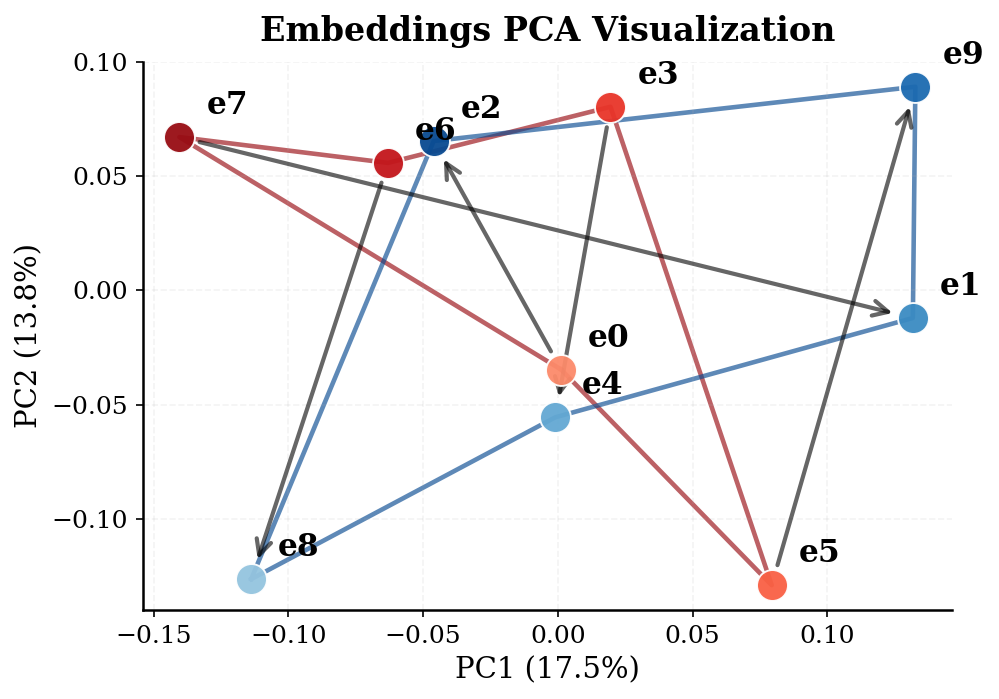

In [41]:
import re, json
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- assume you already have:
# vocab_path (str), model (with tok_emb), f_map_dict (dict like {'<e_5>': '<e_9>', ...})

# --------
# Load vocab + embeddings
# --------
with open(vocab_path, "r", encoding="utf-8") as f:
    vocab = json.load(f)
tok2id = {t: i for i, t in enumerate(vocab)}

W = model.tok_emb.weight.detach().cpu().numpy()  # [V, d]

# --------
ENTITY_RE = re.compile(r"^<e_(\d+)>$")
entity_vocab_ids, entity_ent_ids = [], []
for vid, tok in enumerate(vocab):
    m = ENTITY_RE.match(tok)
    if m:
        entity_vocab_ids.append(vid)
        entity_ent_ids.append(int(m.group(1)))

entity_vocab_ids = np.array(entity_vocab_ids, dtype=np.int64)
entity_ent_ids  = np.array(entity_ent_ids,  dtype=np.int64)

X_ent = W[entity_vocab_ids]  # [E, d]


# --------
# PCA fit on ALL tokens
# --------
pca = PCA(n_components=10, svd_solver="full", random_state=0)
Z_all = pca.fit_transform(X_ent)                     # [V, k]
evr = pca.explained_variance_ratio_

# --------
# Collect all entities (<e_#>) for faint background
# --------
ENTITY_RE = re.compile(r"^<e_(\d+)>$")
entity_vocab_ids, entity_ent_ids = [], []
for vid, tok in enumerate(vocab):
    m = ENTITY_RE.match(tok)
    if m:
        entity_vocab_ids.append(vid)
        entity_ent_ids.append(int(m.group(1)))

entity_vocab_ids = np.array(entity_vocab_ids, dtype=np.int64)
entity_ent_ids  = np.array(entity_ent_ids,  dtype=np.int64)
Z_ent = Z_all[entity_vocab_ids]                  # [E, k]
vid_to_entity_index = {int(vid): i for i, vid in enumerate(entity_vocab_ids)}

def token_to_ent_xy(tok: str):
    if tok not in tok2id:
        raise ValueError(f"token not in vocab: {tok}")
    vid = tok2id[tok]
    if vid not in vid_to_entity_index:
        raise ValueError(f"token is not an entity token: {tok}")
    ei = vid_to_entity_index[vid]
    x, y = Z_ent[ei, 0], Z_ent[ei, 1]
    ent_id = entity_ent_ids[ei]
    return x, y, ent_id, ei

# --------
# Build arrays for left/right points from mapping
# --------
left_toks  = list(f_map_dict.keys())
right_toks = [f_map_dict[k] for k in left_toks]

left_xy, right_xy = [], []
left_ids, right_ids = [], []
left_eidx, right_eidx = [], []

for lt, rt in zip(left_toks, right_toks):
    lx, ly, lid, lei = token_to_ent_xy(lt)
    rx, ry, rid, rei = token_to_ent_xy(rt)
    left_xy.append((lx, ly));  right_xy.append((rx, ry))
    left_ids.append(lid);      right_ids.append(rid)
    left_eidx.append(lei);     right_eidx.append(rei)

left_xy  = np.array(left_xy, dtype=float)   # [n,2]
right_xy = np.array(right_xy, dtype=float)

# Background: all entities except those involved in mapping
mask_bg = np.ones(len(Z_ent), dtype=bool)
mask_bg[np.array(left_eidx, dtype=int)] = False
mask_bg[np.array(right_eidx, dtype=int)] = False
Z_bg = Z_ent[mask_bg]

# --------
# helper: connect points as a polygon by angle order (pentagon-ish)
# --------
def polygon_order(points_xy: np.ndarray) -> np.ndarray:
    """Return indices that sort points around centroid by polar angle."""
    c = points_xy.mean(axis=0, keepdims=True)  # [1,2]
    angles = np.arctan2(points_xy[:, 1] - c[0, 1], points_xy[:, 0] - c[0, 0])
    return np.argsort(angles)

def draw_polygon(ax, points_xy: np.ndarray, order: np.ndarray, *, lw=2.0, alpha=0.8, color=None):
    """Draw closed polygon following order."""
    P = points_xy[order]
    P_closed = np.vstack([P, P[0:1]])
    ax.plot(P_closed[:, 0], P_closed[:, 1], linewidth=lw, alpha=alpha, color=color, zorder=1)

# compute polygon orders for left/right
ord_L = polygon_order(left_xy)
ord_R = polygon_order(right_xy)

# --------
# Gradual colors per entity (by polygon order)
# --------
nL = len(left_xy)
nR = len(right_xy)

cmap_L = cm.get_cmap("Reds")
cmap_R = cm.get_cmap("Blues")

# choose a nice range: avoid too pale / too dark
colors_L = cmap_L(np.linspace(0.40, 0.90, nL))  # [nL,4]
colors_R = cmap_R(np.linspace(0.40, 0.90, nR))

# map each point index -> color (following polygon order)
left_color_by_idx = np.zeros((nL, 4))
right_color_by_idx = np.zeros((nR, 4))
for rank, idx in enumerate(ord_L):
    left_color_by_idx[idx] = colors_L[rank]
for rank, idx in enumerate(ord_R):
    right_color_by_idx[idx] = colors_R[rank]

# --------
# Plot
# --------
fig, ax = plt.subplots(figsize=(7, 5))

# faint background entities
ax.scatter(Z_bg[:, 0], Z_bg[:, 1], s=18, alpha=0.10, linewidths=0, edgecolors="none", zorder=0)

# connect within domain (pentagon)
draw_polygon(ax, left_xy,  ord_L, lw=2.2, alpha=0.65, color=colors_L[-1])
draw_polygon(ax, right_xy, ord_R, lw=2.2, alpha=0.65, color=colors_R[-1])

# left / right highlighted with gradual colors
s_big = 220
for i in range(nL):
    ax.scatter(
        left_xy[i, 0], left_xy[i, 1],
        s=s_big, alpha=0.95,
        linewidths=0.9, edgecolors="white",
        color=left_color_by_idx[i],
        zorder=3
    )
for i in range(nR):
    ax.scatter(
        right_xy[i, 0], right_xy[i, 1],
        s=s_big, alpha=0.95,
        linewidths=0.9, edgecolors="white",
        color=right_color_by_idx[i],
        zorder=3
    )

# arrows left -> right + labels (arrow colored by left color)
for (lx, ly), (rx, ry), lid, rid, cL in zip(left_xy, right_xy, left_ids, right_ids, left_color_by_idx):
    ax.annotate(
        "",
        xy=(rx, ry), xytext=(lx, ly),
        arrowprops=dict(
            arrowstyle="->",
            lw=2,
            alpha=0.60,
            color="black",
            shrinkA=10, shrinkB=10
        ),
        zorder=2
    )
    ax.text(lx + 0.01, ly + 0.01, f"e{lid}", fontsize=15, weight="bold", zorder=4)
    ax.text(rx + 0.01, ry + 0.01, f"e{rid}", fontsize=15, weight="bold", zorder=4)

# cosmetics
ax.set_title("Embeddings PCA Visualization", pad=10, fontsize=16, weight="bold")
ax.set_xlabel(f"PC1 ({evr[0]*100:.1f}%)", fontsize=14)
ax.set_ylabel(f"PC2 ({evr[1]*100:.1f}%)", fontsize=14)

ax.grid(True, alpha=0.15, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ticks smaller
ax.tick_params(axis="both", which="major", labelsize=12)
ax.minorticks_off()

# keep geometry undistorted (optional but usually nice)
# ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.savefig("pca_visualization_start_training.pdf")
plt.show()


# Energy

In [42]:
model = GPT2LikeEncoder(len(train_ds.vocab), d_model=d_model, n_layer=n_layer, n_head=n_head, dropout=dropout, max_len=max_len).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
sched = WarmupThenConstant(opt, warmup_steps=warmup_steps)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

/tmp/ipython-input-865839494.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [43]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

def build_edge_index_from_fmap(f_map_dict, tok2id, *, undirected=True, device="cpu"):
    src, dst = [], []
    for s_tok, t_tok in f_map_dict.items():
        if s_tok not in tok2id or t_tok not in tok2id:
            continue
        i = tok2id[s_tok]
        j = tok2id[t_tok]
        src.append(i); dst.append(j)
        if undirected:
            src.append(j); dst.append(i)

    if len(src) == 0:
        raise ValueError("No valid edges from f_map_dict")

    return torch.tensor([src, dst], dtype=torch.long, device=device)

@torch.no_grad()
def dirichlet_energy(emb_weight, edge_index):
    """
    emb_weight: [V, d]
    edge_index: [2, M]
    """
    src, dst = edge_index
    emb = F.normalize(emb_weight, dim=-1)
    dif = emb[src] - emb[dst]                 # [M, d]
    per_edge = (dif * dif).sum(dim=-1)         # squared L2
    return per_edge.mean()

@torch.no_grad()
def correct_prob(sel_logits, sel_targets):
    probs = F.softmax(sel_logits, dim=-1)
    p = probs.gather(1, sel_targets.view(-1,1)).squeeze(1)
    return p.mean().item()

@torch.no_grad()
def compute_functor_quality_metrics(model, f_map_dict, tok2id, device):
    """
    Compute comprehensive metrics for functor (category mapping) quality.
    
    Metrics:
    1. translation_consistency: How consistent are the translation vectors (f(e) - e)?
    2. parallelogram_score: Does ei - ej ≈ f(ei) - f(ej) hold? (classic analogy property)
    3. isometry_score: Are distances preserved? ||f(ei) - f(ej)|| ≈ ||ei - ej||
    4. cluster_separation: Are E1 and E2 well separated?
    """
    input_emb = model.tok_emb.weight  # [V, d]
    output_emb = model.head.weight    # [V, d]
    
    # Collect embeddings for E1 and E2
    E1_embs = []  # input embeddings of E1 entities
    E2_embs = []  # output embeddings of E2 entities (f(e))
    E1_toks = list(f_map_dict.keys())
    
    for e1_tok in E1_toks:
        e2_tok = f_map_dict[e1_tok]
        e1_idx = tok2id[e1_tok]
        e2_idx = tok2id[e2_tok]
        E1_embs.append(input_emb[e1_idx])
        E2_embs.append(output_emb[e2_idx])
    
    E1_embs = torch.stack(E1_embs)  # [n, d]
    E2_embs = torch.stack(E2_embs)  # [n, d]
    n = E1_embs.shape[0]
    
    # 1. Translation Consistency
    # translation vectors: f(ei) - ei for each pair
    translations = E2_embs - E1_embs  # [n, d]
    mean_trans = translations.mean(dim=0, keepdim=True)  # [1, d]
    trans_variance = ((translations - mean_trans) ** 2).sum(dim=1).mean()  # scalar
    trans_consistency = 1.0 / (1.0 + trans_variance.item())  # higher is better
    
    # 2. Parallelogram Score (using <f> embedding)
    # f(ei) - ei should be similar to e_f (the functor embedding)
    # This is the classic Word2Vec analogy: king - man ≈ queen - woman ≈ "gender direction"
    f_idx = tok2id["<f>"]
    e_f = input_emb[f_idx]  # [d] - the <f> embedding
    e_f_norm = F.normalize(e_f.unsqueeze(0), dim=1)  # [1, d]
    
    parallelogram_scores = []
    analogy_addition_scores = []
    for i in range(n):
        # translation vector: f(ei) - ei
        trans_vec = E2_embs[i] - E1_embs[i]  # [d]
        trans_vec_norm = F.normalize(trans_vec.unsqueeze(0), dim=1)  # [1, d]
        # cosine similarity with <f> embedding: cos(f(ei) - ei, e_f)
        cos = F.cosine_similarity(trans_vec_norm, e_f_norm).item()
        parallelogram_scores.append(cos)
        
        # Analogy addition: ei + e_f ≈ f(ei)?
        predicted = E1_embs[i] + e_f  # [d]
        predicted_norm = F.normalize(predicted.unsqueeze(0), dim=1)
        target_norm = F.normalize(E2_embs[i].unsqueeze(0), dim=1)
        cos_add = F.cosine_similarity(predicted_norm, target_norm).item()
        analogy_addition_scores.append(cos_add)
        
    parallelogram_score = sum(parallelogram_scores) / len(parallelogram_scores) if parallelogram_scores else 0.0
    analogy_addition_score = sum(analogy_addition_scores) / len(analogy_addition_scores) if analogy_addition_scores else 0.0
    
    # 3. Isometry Score (distance preservation)
    # ||f(ei) - f(ej)|| should be proportional to ||ei - ej||
    E1_dists = []
    E2_dists = []
    for i in range(n):
        for j in range(i+1, n):
            E1_dists.append(torch.norm(E1_embs[i] - E1_embs[j]).item())
            E2_dists.append(torch.norm(E2_embs[i] - E2_embs[j]).item())
    if E1_dists:
        E1_dists = torch.tensor(E1_dists)
        E2_dists = torch.tensor(E2_dists)
        # Pearson correlation between distances
        E1_centered = E1_dists - E1_dists.mean()
        E2_centered = E2_dists - E2_dists.mean()
        isometry_score = (E1_centered * E2_centered).sum() / (
            torch.sqrt((E1_centered**2).sum() * (E2_centered**2).sum()) + 1e-8
        )
        isometry_score = isometry_score.item()
    else:
        isometry_score = 0.0
    
    # 4. Cluster Separation (using centroid distance / average within-cluster spread)
    E1_centroid = E1_embs.mean(dim=0)
    E2_centroid = E2_embs.mean(dim=0)
    centroid_dist = torch.norm(E1_centroid - E2_centroid).item()
    E1_spread = torch.norm(E1_embs - E1_centroid, dim=1).mean().item()
    E2_spread = torch.norm(E2_embs - E2_centroid, dim=1).mean().item()
    avg_spread = (E1_spread + E2_spread) / 2
    cluster_separation = centroid_dist / (avg_spread + 1e-8)
    
    return {
        "translation_consistency": trans_consistency,
        "parallelogram_score": parallelogram_score,        # cos(f(ei) - ei, e_f)
        "analogy_addition_score": analogy_addition_score,  # cos(ei + e_f, f(ei))
        "isometry_score": isometry_score,
        "cluster_separation": cluster_separation,
    }

@torch.no_grad()
def compute_analogy_accuracy_metrics(model, batch, tok2id, f_map_dict, device):
    """
    Compute accuracy-based metrics for analogy samples:
    - hit_at_1: Is the nearest neighbor of hi equal to ej?
    - mrr: Mean Reciprocal Rank of ej
    - direct_cos_sim: cos(hi, ej) - how close is prediction to target?
    """
    input_ids = batch["input_ids"].to(device)
    target_ids = batch["target_ids"].to(device)
    loss_mask = batch["loss_mask"].to(device)
    types = batch.get("type", None)
    
    if types is None:
        return {}
    
    input_emb = model.tok_emb.weight
    output_emb = model.head.weight
    d_model = input_emb.shape[1]
    
    qkv_weight = model.blocks[0].attn.qkv.weight
    Wv = qkv_weight[2*d_model:, :]
    Wo = model.blocks[0].attn.out.weight  # [d, d] - output projection
    ln_1 = model.blocks[0].ln_1  # LayerNorm before attention
    
    # Get all E2 entity indices for ranking
    E2_indices = [tok2id[v] for v in f_map_dict.values()]
    E2_embs = output_emb[E2_indices]  # [n_E2, d]
    
    results = {"id_analogical": [], "ood_analogical": []}
    
    B = input_ids.shape[0]
    for b in range(B):
        t = types[b]
        if t not in ["id_analogical", "ood_analogical"]:
            continue
        
        first_tok_id = input_ids[b, 0].item()
        ei = input_emb[first_tok_id]
        ei_ln = ln_1(ei)    # LayerNorm (same as model)
        v = ei_ln @ Wv.T    # V projection
        hi = v @ Wo.T       # Output projection
        
        last_pos = loss_mask[b].nonzero(as_tuple=True)[0][-1].item()
        target_tok_id = target_ids[b, last_pos].item()
        ej = output_emb[target_tok_id]
        
        # Direct cosine similarity
        hi_norm = F.normalize(hi, dim=0)
        ej_norm = F.normalize(ej, dim=0)
        direct_cos = (hi_norm * ej_norm).sum().item()
        
        # Ranking: compute similarity to all E2 entities
        sims = F.cosine_similarity(hi.unsqueeze(0), E2_embs)  # [n_E2]
        sorted_indices = sims.argsort(descending=True)
        
        # Find rank of correct answer
        target_E2_pos = E2_indices.index(target_tok_id) if target_tok_id in E2_indices else -1
        if target_E2_pos >= 0:
            rank = (sorted_indices == target_E2_pos).nonzero(as_tuple=True)[0].item() + 1
            hit_at_1 = 1.0 if rank == 1 else 0.0
            mrr = 1.0 / rank
        else:
            hit_at_1 = 0.0
            mrr = 0.0
        
        results[t].append({
            "direct_cos": direct_cos,
            "hit_at_1": hit_at_1,
            "mrr": mrr,
        })
    
    metrics = {}
    for t in ["id_analogical", "ood_analogical"]:
        if results[t]:
            metrics[f"{t}_direct_cos"] = sum(r["direct_cos"] for r in results[t]) / len(results[t])
            metrics[f"{t}_hit_at_1"] = sum(r["hit_at_1"] for r in results[t]) / len(results[t])
            metrics[f"{t}_mrr"] = sum(r["mrr"] for r in results[t]) / len(results[t])
    
    return metrics

@torch.no_grad()
def compute_analogy_metric(model, batch, tok2id, device):
    """
    Compute the analogy metric for id/ood_analogical samples:
    - ei: embedding of first entity (input's first token) from tok_emb
    - hi: normalize(ei) @ Wv  
    - ej: target entity's row vector from output head (model.head.weight)
    - e_f: embedding of <f> from tok_emb
    - similarity: cos_sim(hi - ej, e_f)
    
    Returns dict with metrics for id_analogical and ood_analogical separately.
    """
    input_ids = batch["input_ids"].to(device)   # [B, L]
    target_ids = batch["target_ids"].to(device) # [B, L]
    loss_mask = batch["loss_mask"].to(device)   # [B, L]
    types = batch.get("type", None)
    
    if types is None:
        return {}
    
    # Get embedding weights
    input_emb_weight = model.tok_emb.weight  # [V, d] - input embedding
    output_emb_weight = model.head.weight    # [V, d] - output head (last linear layer)
    d_model = input_emb_weight.shape[1]
    
    # Extract Wv from qkv projection (last d_model rows)
    # qkv.weight shape: [3*d_model, d_model]
    qkv_weight = model.blocks[0].attn.qkv.weight  # [3*d, d]
    Wv = qkv_weight[2*d_model:, :]  # [d, d]
    Wo = model.blocks[0].attn.out.weight  # [d, d] - output projection
    ln_1 = model.blocks[0].ln_1  # LayerNorm before attention
    
    # Get <f> embedding from input embedding
    f_idx = tok2id["<f>"]
    e_f = input_emb_weight[f_idx]  # [d]
    e_f_norm = F.normalize(e_f, dim=0)  # [d]
    
    results = {"id_analogical": [], "ood_analogical": []}
    
    B = input_ids.shape[0]
    for b in range(B):
        t = types[b]
        if t not in ["id_analogical", "ood_analogical"]:
            continue
        
        # Get first entity embedding (position 0) from input embedding
        first_tok_id = input_ids[b, 0].item()
        ei = input_emb_weight[first_tok_id]  # [d]
        
        # Compute hi = LN(ei) @ Wv @ Wo (full attention output projection)
        ei_ln = ln_1(ei)    # [d] - LayerNorm (same as model)
        v = ei_ln @ Wv.T    # [d] - V projection
        hi = v @ Wo.T       # [d] - Output projection
        
        # Get target entity from output head (last linear layer)
        last_pos = loss_mask[b].nonzero(as_tuple=True)[0][-1].item()
        target_tok_id = target_ids[b, last_pos].item()
        ej = input_emb_weight[target_tok_id]  # [d] - from head.weight
        
        # Compute hi - ej
        diff = ej - hi  # [d]
        diff_norm = F.normalize(diff, dim=0)  # [d]
        
        # Cosine similarity with <f> embedding
        cos_sim = (diff_norm * e_f_norm).sum().item()
        
        results[t].append(cos_sim)
    
    # Compute averages
    metrics = {}
    for t in ["id_analogical", "ood_analogical"]:
        if results[t]:
            metrics[f"{t}_hi_ej_f_sim"] = sum(results[t]) / len(results[t])
    
    return metrics

def step_loss(model, batch):
    input_ids = batch["input_ids"].to(device)
    target_ids = batch["target_ids"].to(device)
    loss_mask  = batch["loss_mask"].to(device)
    pad_mask   = batch.get("pad_mask", None)
    if pad_mask is not None:
        pad_mask = pad_mask.to(device)

    with torch.cuda.amp.autocast(enabled=use_amp):
        logits = model(input_ids, pad_mask=pad_mask)
        B,L,V = logits.shape
        logits_f  = logits.view(B*L, V)
        targets_f = target_ids.view(B*L)
        mask_f    = loss_mask.view(B*L)

        sel_logits  = logits_f[mask_f]
        sel_targets = targets_f[mask_f]
        loss = F.cross_entropy(sel_logits, sel_targets)

    with torch.no_grad():
        acc = (sel_logits.argmax(dim=-1) == sel_targets).float().mean().item()

    return loss, acc, sel_logits.detach(), sel_targets.detach()


edge_index = build_edge_index_from_fmap(
    f_map_dict, tok2id, undirected=True, device=device
)

history = {
    "step": [],
    "dirichlet": [],
    "pcorr": [],
    "ce": [],
    "id_analogical_hi_ej_f_sim": [],
    "ood_analogical_hi_ej_f_sim": [],
    # Functor quality metrics
    "translation_consistency": [],
    "parallelogram_score": [],       # cos(f(ei) - ei, e_f)
    "analogy_addition_score": [],    # cos(ei + e_f, f(ei))
    "isometry_score": [],
    "cluster_separation": [],
    # Accuracy metrics
    "id_analogical_direct_cos": [],
    "ood_analogical_direct_cos": [],
    "id_analogical_hit_at_1": [],
    "ood_analogical_hit_at_1": [],
    "id_analogical_mrr": [],
    "ood_analogical_mrr": [],
}

best_val = float("inf")
global_step = 0
log_every = 50

for epoch in range(1, epochs + 1):
    model.train()
    running, n_ex = 0.0, 0

    for i, batch in enumerate(train_dl, 1):
        loss, acc, sel_logits, sel_targets = step_loss(model, batch)

        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        sched.step()

        bs = batch["input_ids"].size(0)
        running += loss.item() * bs
        n_ex += bs
        global_step += 1

        if i % log_every == 0 or i == 1:
            with torch.no_grad():
                energy = dirichlet_energy(model.tok_emb.weight, edge_index).item()
                pcorr  = correct_prob(sel_logits, sel_targets)
                
                # Compute analogy metric on test_dl (which has type info)
                analogy_metrics = {}
                model.eval()
                for test_batch in test_dl:
                    batch_metrics = compute_analogy_metric(model, test_batch, tok2id, device)
                    for k, v in batch_metrics.items():
                        if k not in analogy_metrics:
                            analogy_metrics[k] = []
                        analogy_metrics[k].append(v)
                model.train()
                
                # Average the analogy metrics
                id_sim = sum(analogy_metrics.get("id_analogical_hi_ej_f_sim", [0])) / max(1, len(analogy_metrics.get("id_analogical_hi_ej_f_sim", [0])))
                ood_sim = sum(analogy_metrics.get("ood_analogical_hi_ej_f_sim", [0])) / max(1, len(analogy_metrics.get("ood_analogical_hi_ej_f_sim", [0])))
                
                # Compute functor quality metrics
                functor_metrics = compute_functor_quality_metrics(model, f_map_dict, tok2id, device)
                
                # Compute accuracy metrics
                accuracy_metrics = {}
                for test_batch in test_dl:
                    batch_acc_metrics = compute_analogy_accuracy_metrics(model, test_batch, tok2id, f_map_dict, device)
                    for k, v in batch_acc_metrics.items():
                        if k not in accuracy_metrics:
                            accuracy_metrics[k] = []
                        accuracy_metrics[k].append(v)
                
                # Average accuracy metrics
                avg_acc_metrics = {k: sum(v)/len(v) if v else 0.0 for k, v in accuracy_metrics.items()}

            history["step"].append(global_step)
            history["dirichlet"].append(energy)
            history["pcorr"].append(pcorr)
            history["ce"].append(loss.item())
            history["id_analogical_hi_ej_f_sim"].append(id_sim)
            history["ood_analogical_hi_ej_f_sim"].append(ood_sim)
            
            # Functor quality metrics
            history["translation_consistency"].append(functor_metrics["translation_consistency"])
            history["parallelogram_score"].append(functor_metrics["parallelogram_score"])
            history["analogy_addition_score"].append(functor_metrics["analogy_addition_score"])
            history["isometry_score"].append(functor_metrics["isometry_score"])
            history["cluster_separation"].append(functor_metrics["cluster_separation"])
            
            # Accuracy metrics
            history["id_analogical_direct_cos"].append(avg_acc_metrics.get("id_analogical_direct_cos", 0.0))
            history["ood_analogical_direct_cos"].append(avg_acc_metrics.get("ood_analogical_direct_cos", 0.0))
            history["id_analogical_hit_at_1"].append(avg_acc_metrics.get("id_analogical_hit_at_1", 0.0))
            history["ood_analogical_hit_at_1"].append(avg_acc_metrics.get("ood_analogical_hit_at_1", 0.0))
            history["id_analogical_mrr"].append(avg_acc_metrics.get("id_analogical_mrr", 0.0))
            history["ood_analogical_mrr"].append(avg_acc_metrics.get("ood_analogical_mrr", 0.0))

    train_ce = running / max(1, n_ex)
    if epoch % 50 == 0:
        print(f"epoch {epoch} | train CE: {train_ce:.4f}")

    # validation
    metrics = evaluate_split_by_type(model, test_dl)
    ce_macro = sum(m["CE"] for m in metrics.values()) / len(metrics)

    if ce_macro < best_val:
        best_val = ce_macro
        # torch.save({"model": model.state_dict()}, f"{save_dir}/best.pt")




/tmp/ipython-input-1288381299.py:307: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


epoch 50 | train CE: 4.6858
epoch 100 | train CE: 1.7401
epoch 150 | train CE: 0.7309
epoch 200 | train CE: 0.3454
epoch 250 | train CE: 0.1935
epoch 300 | train CE: 0.1236


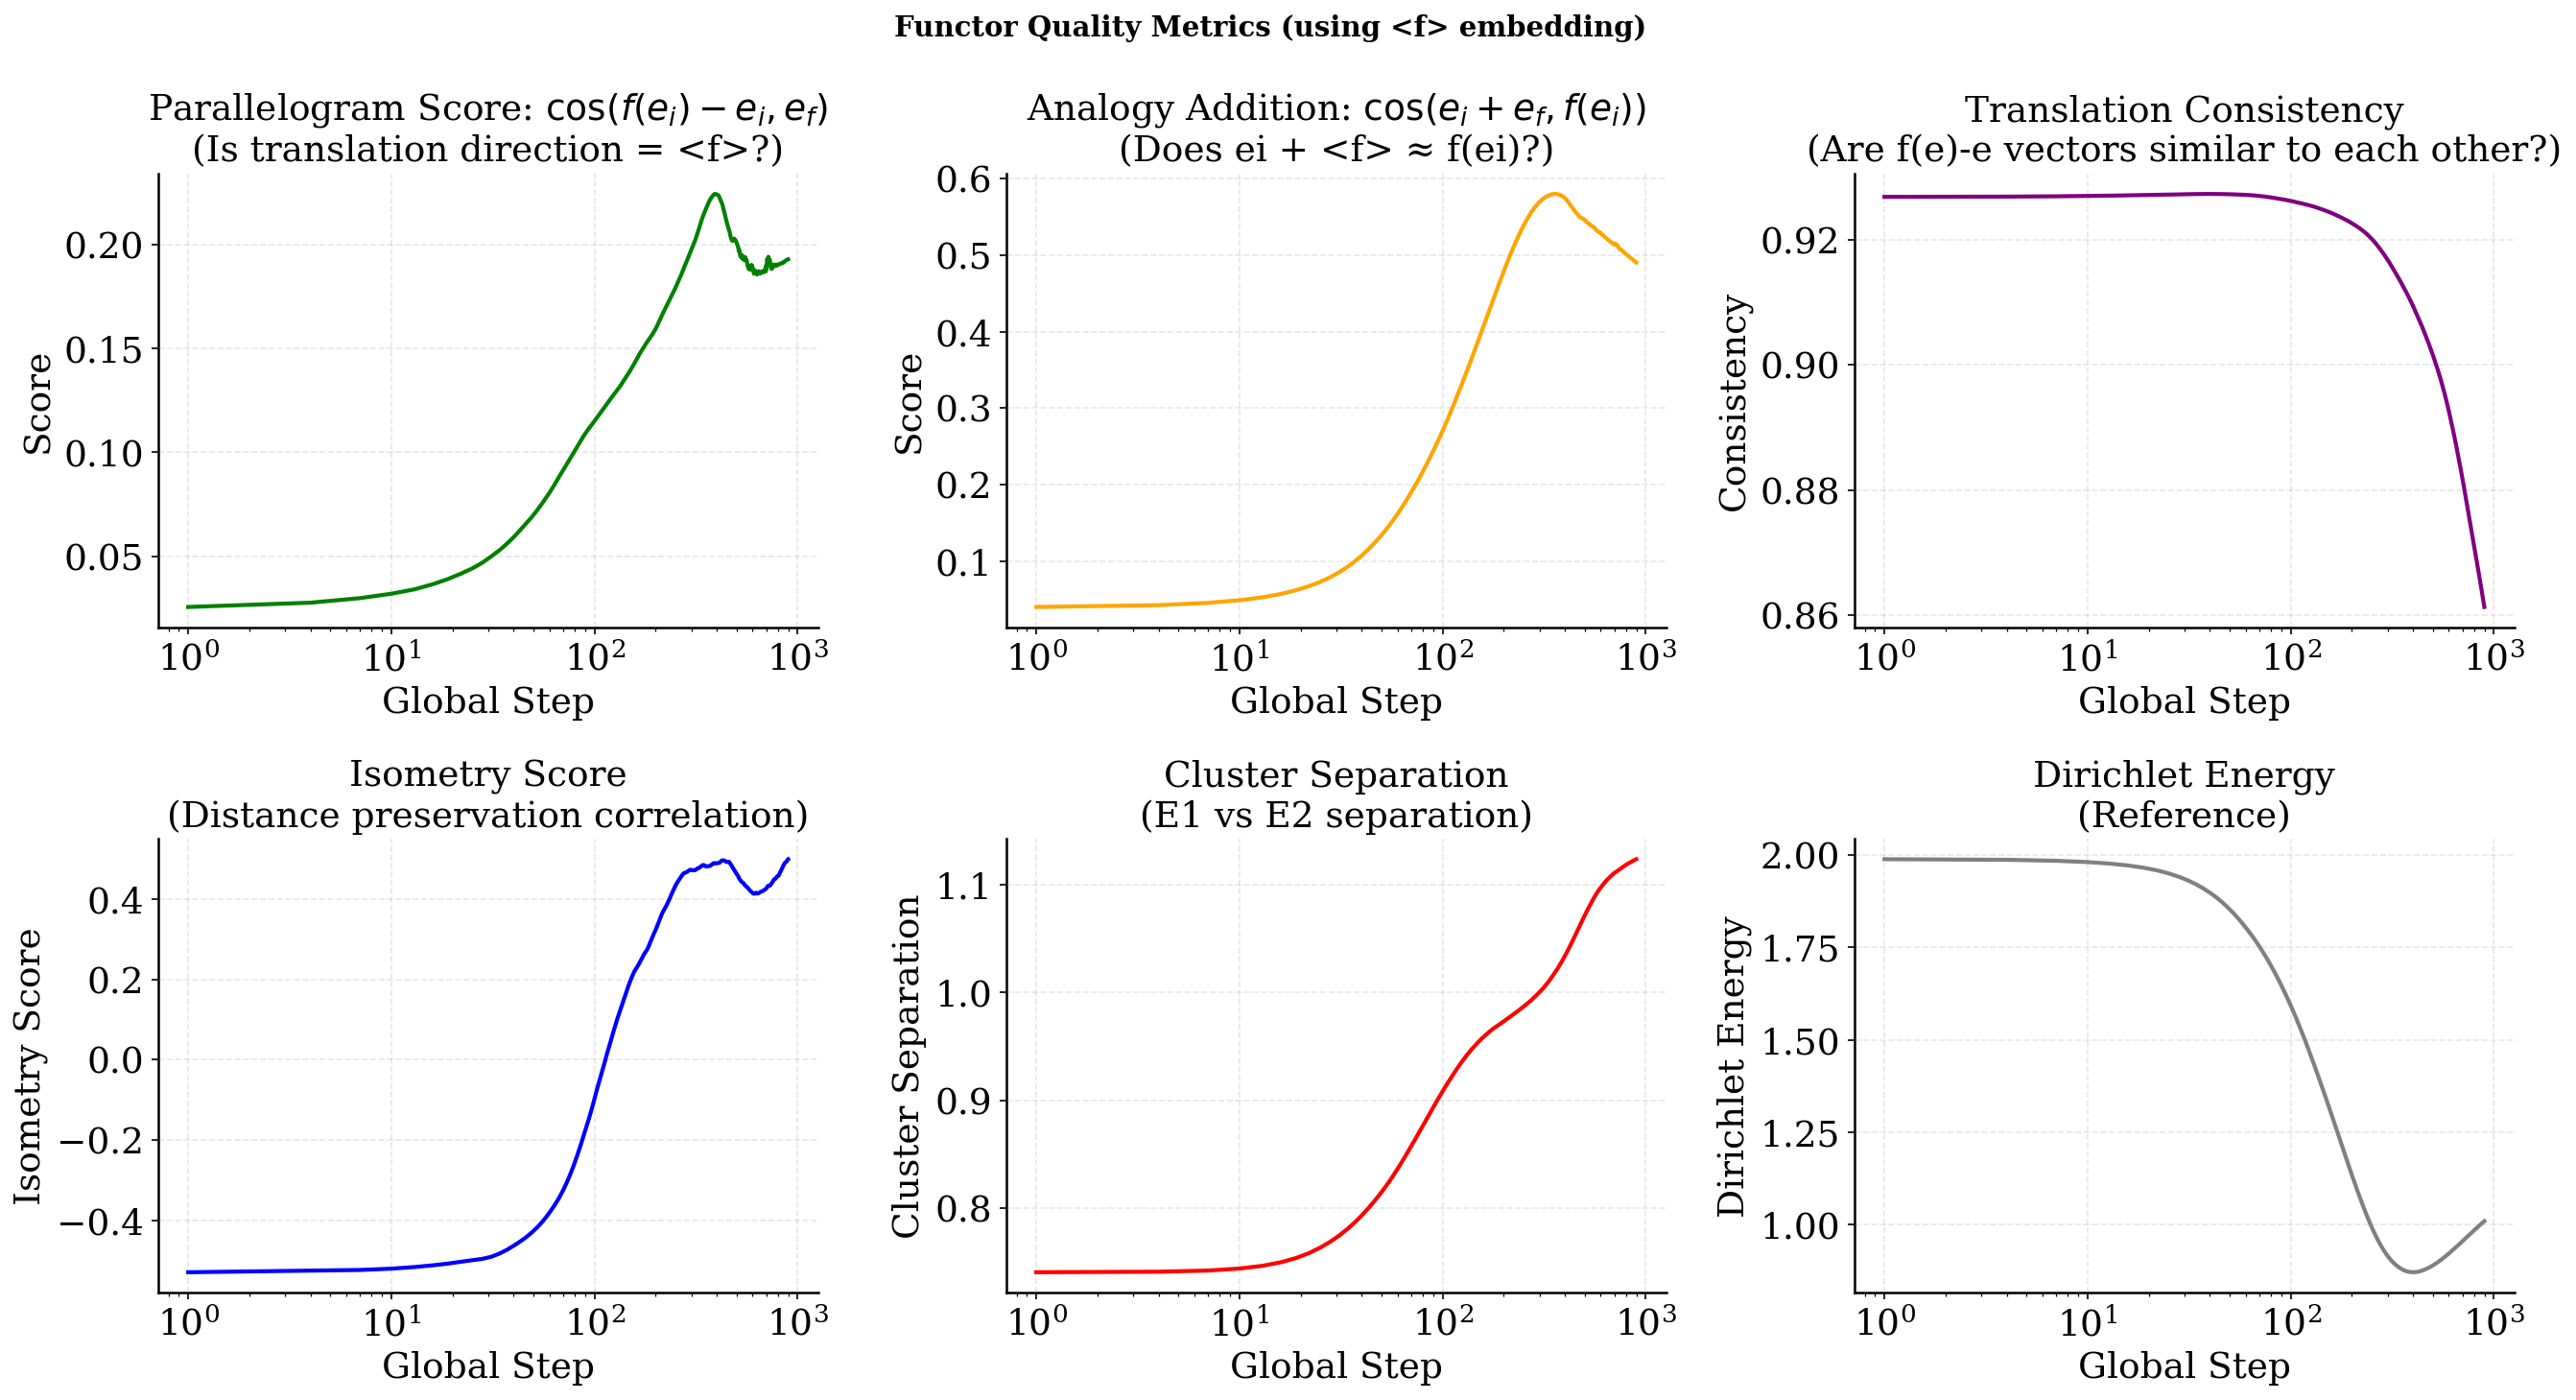

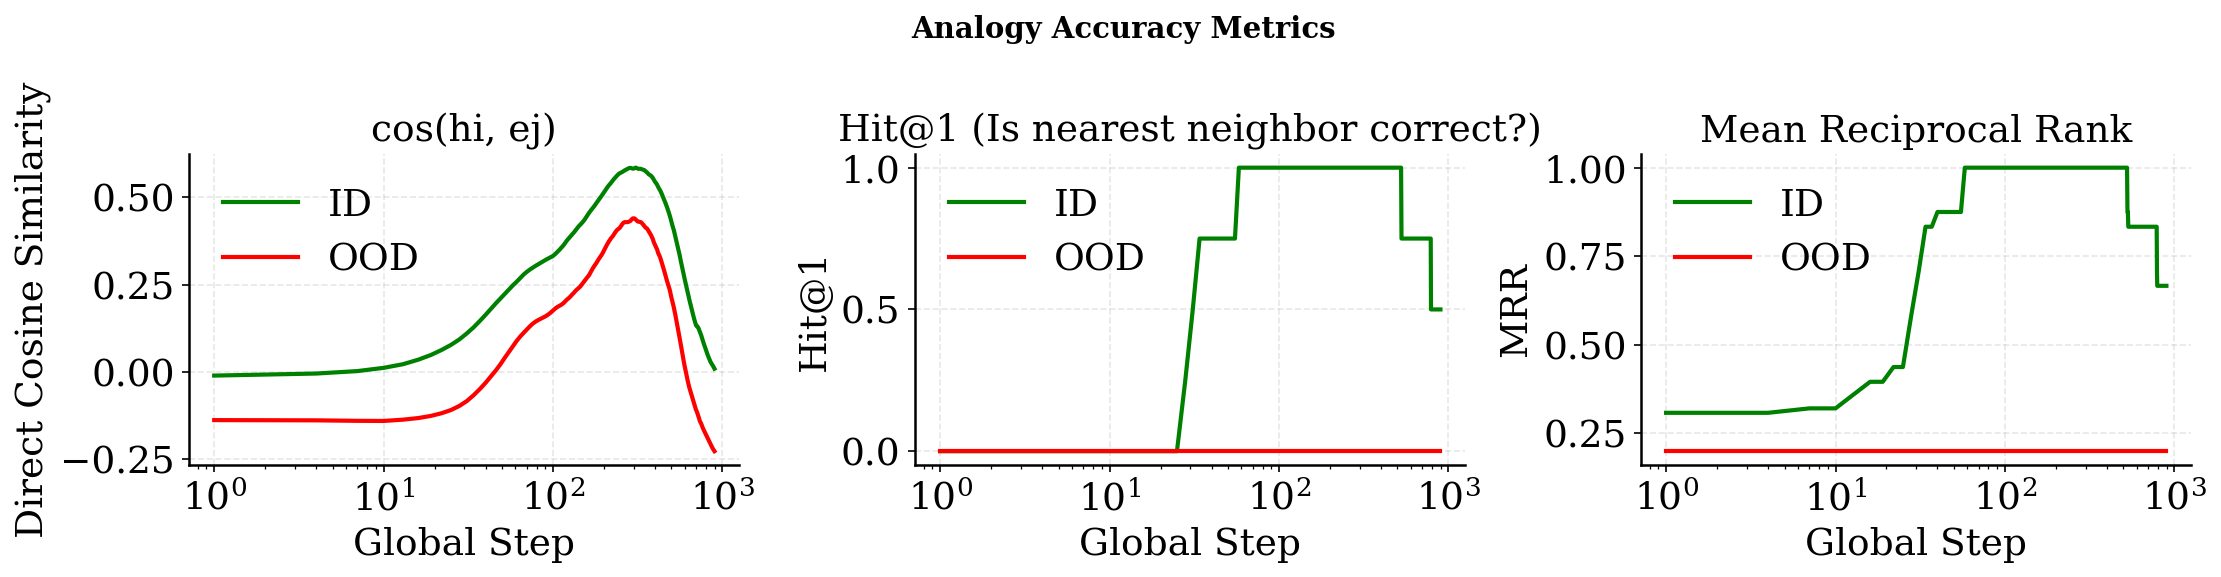

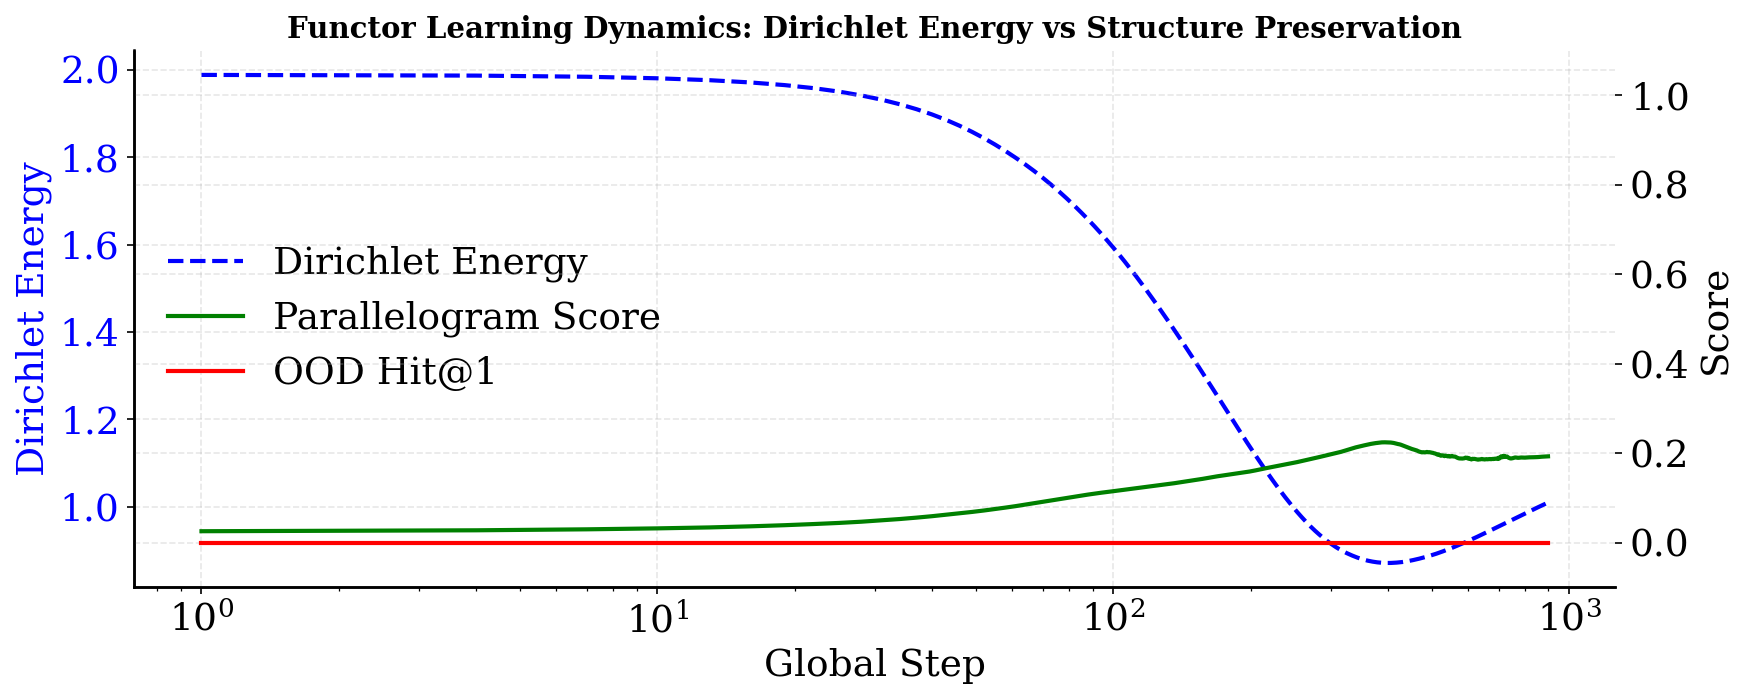

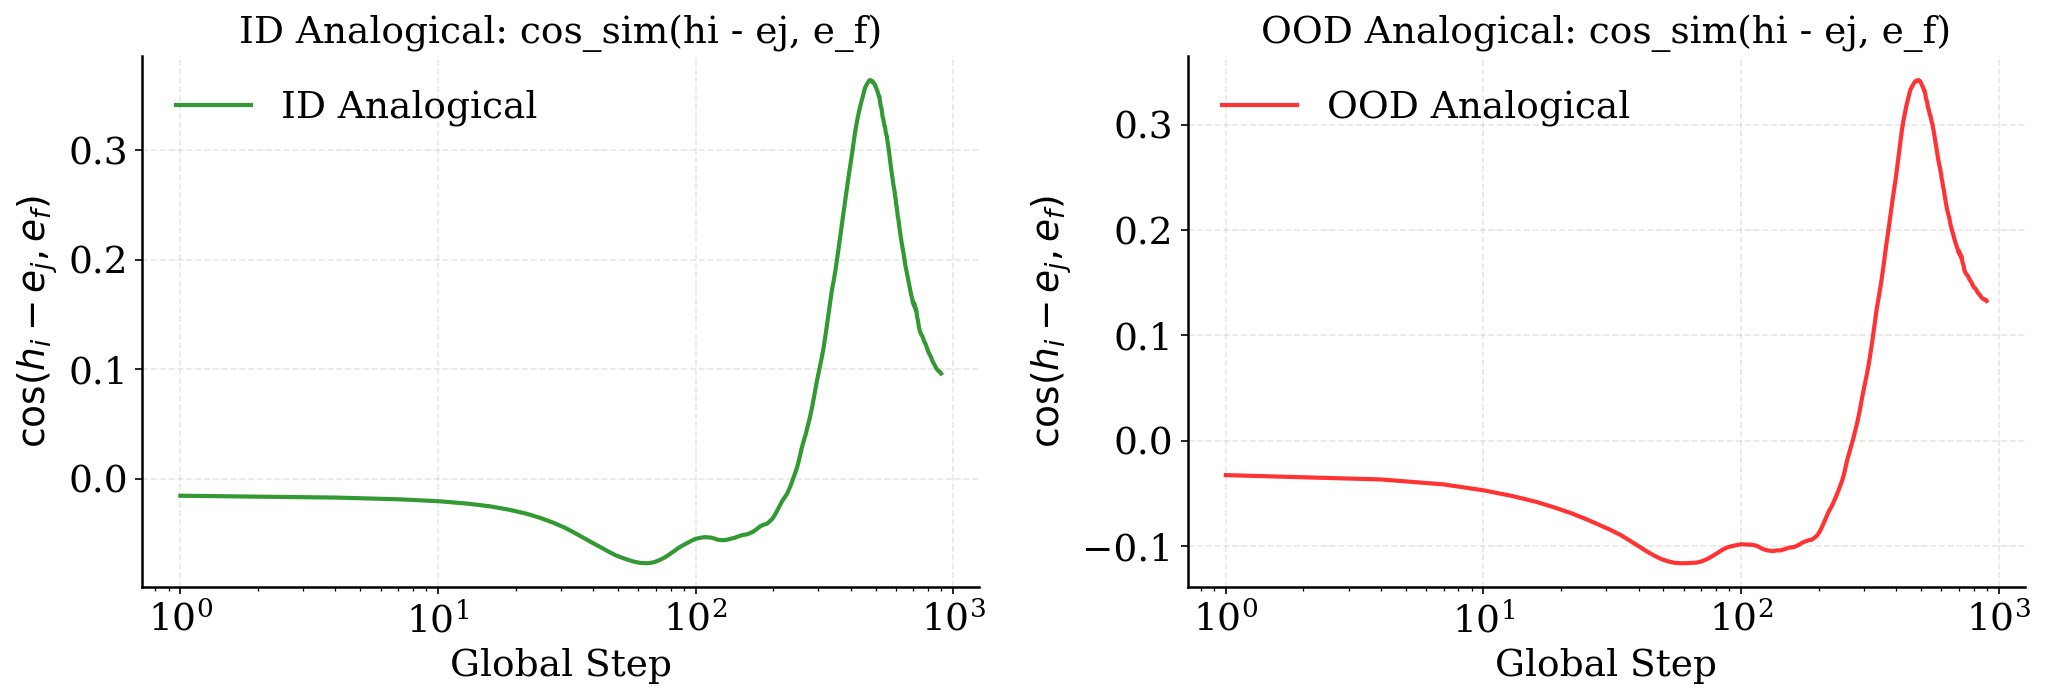

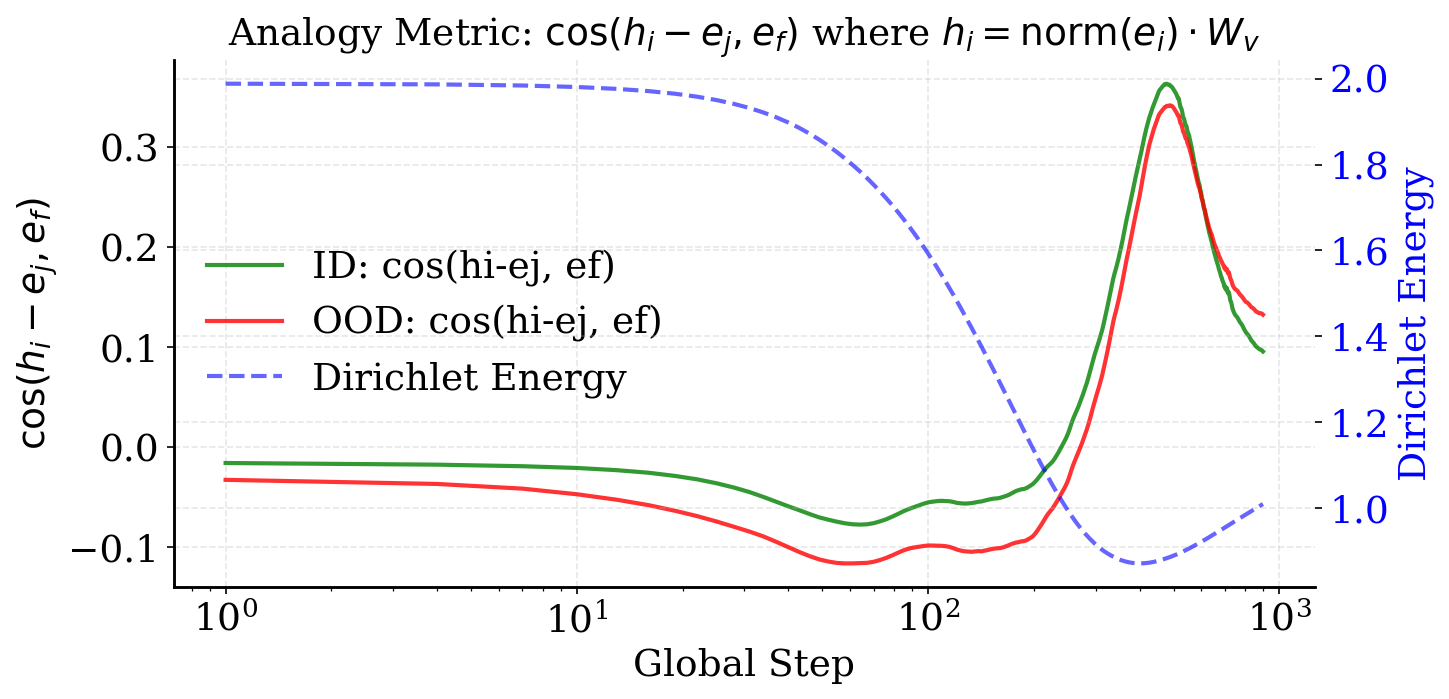

In [44]:
# ===== Comprehensive Functor Quality Visualization =====

# 1. Functor Quality Metrics (using <f> embedding)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ax = axes[0, 0]
ax.plot(history["step"], history["parallelogram_score"], color="green", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Score")
ax.set_title(r"Parallelogram Score: $\cos(f(e_i) - e_i, e_f)$" + "\n(Is translation direction = <f>?)")
ax.set_xscale("log")
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.plot(history["step"], history["analogy_addition_score"], color="orange", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Score")
ax.set_title(r"Analogy Addition: $\cos(e_i + e_f, f(e_i))$" + "\n(Does ei + <f> ≈ f(ei)?)")
ax.set_xscale("log")
ax.grid(alpha=0.3)

ax = axes[0, 2]
ax.plot(history["step"], history["translation_consistency"], color="purple", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Consistency")
ax.set_title("Translation Consistency\n(Are f(e)-e vectors similar to each other?)")
ax.set_xscale("log")
ax.grid(alpha=0.3)

ax = axes[1, 0]
ax.plot(history["step"], history["isometry_score"], color="blue", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Isometry Score")
ax.set_title("Isometry Score\n(Distance preservation correlation)")
ax.set_xscale("log")
ax.grid(alpha=0.3)

ax = axes[1, 1]
ax.plot(history["step"], history["cluster_separation"], color="red", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Cluster Separation")
ax.set_title("Cluster Separation\n(E1 vs E2 separation)")
ax.set_xscale("log")
ax.grid(alpha=0.3)

ax = axes[1, 2]
ax.plot(history["step"], history["dirichlet"], color="gray", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Dirichlet Energy")
ax.set_title("Dirichlet Energy\n(Reference)")
ax.set_xscale("log")
ax.grid(alpha=0.3)

plt.suptitle("Functor Quality Metrics (using <f> embedding)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("functor_quality_metrics.pdf")
plt.show()

# 2. Accuracy-based Metrics (Hit@1, MRR, Direct Cos Sim)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(history["step"], history["id_analogical_direct_cos"], label="ID", color="green", linewidth=2)
ax.plot(history["step"], history["ood_analogical_direct_cos"], label="OOD", color="red", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Direct Cosine Similarity")
ax.set_title("cos(hi, ej)")
ax.set_xscale("log")
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(history["step"], history["id_analogical_hit_at_1"], label="ID", color="green", linewidth=2)
ax.plot(history["step"], history["ood_analogical_hit_at_1"], label="OOD", color="red", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("Hit@1")
ax.set_title("Hit@1 (Is nearest neighbor correct?)")
ax.set_xscale("log")
ax.legend()
ax.grid(alpha=0.3)

ax = axes[2]
ax.plot(history["step"], history["id_analogical_mrr"], label="ID", color="green", linewidth=2)
ax.plot(history["step"], history["ood_analogical_mrr"], label="OOD", color="red", linewidth=2)
ax.set_xlabel("Global Step")
ax.set_ylabel("MRR")
ax.set_title("Mean Reciprocal Rank")
ax.set_xscale("log")
ax.legend()
ax.grid(alpha=0.3)

plt.suptitle("Analogy Accuracy Metrics", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("analogy_accuracy_metrics.pdf")
plt.show()

# 3. Combined Overview: Dirichlet + Parallelogram + Hit@1
fig, ax1 = plt.subplots(figsize=(12, 5))

l1, = ax1.plot(history["step"], history["dirichlet"], color="blue", linewidth=2, linestyle="--", label="Dirichlet Energy")
ax1.set_xlabel("Global Step")
ax1.set_ylabel("Dirichlet Energy", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xscale("log")

ax2 = ax1.twinx()
l2, = ax2.plot(history["step"], history["parallelogram_score"], color="green", linewidth=2, label="Parallelogram Score")
l3, = ax2.plot(history["step"], history["ood_analogical_hit_at_1"], color="red", linewidth=2, label="OOD Hit@1")
ax2.set_ylabel("Score", color="black")
ax2.set_ylim(-0.1, 1.1)

lines = [l1, l2, l3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="center left")
ax1.grid(alpha=0.3)
ax1.set_title("Functor Learning Dynamics: Dirichlet Energy vs Structure Preservation", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("functor_learning_dynamics.pdf")
plt.show()

# ===== Original Visualization =====
# Visualize the analogy metric: cos_sim(hi - ej, e_f)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: ID analogical similarity
ax1 = axes[0]
ax1.plot(history["step"], history["id_analogical_hi_ej_f_sim"], 
         color="green", alpha=0.8, linewidth=2, label="ID Analogical")
ax1.set_xlabel("Global Step")
ax1.set_ylabel(r"$\cos(h_i - e_j, e_f)$")
ax1.set_title("ID Analogical: cos_sim(hi - ej, e_f)")
ax1.set_xscale("log")
ax1.grid(alpha=0.3)
ax1.legend()

# Right plot: OOD analogical similarity  
ax2 = axes[1]
ax2.plot(history["step"], history["ood_analogical_hi_ej_f_sim"],
         color="red", alpha=0.8, linewidth=2, label="OOD Analogical")
ax2.set_xlabel("Global Step")
ax2.set_ylabel(r"$\cos(h_i - e_j, e_f)$")
ax2.set_title("OOD Analogical: cos_sim(hi - ej, e_f)")
ax2.set_xscale("log")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("analogy_metric_hi_ej_f_similarity.pdf")
plt.show()

# Combined plot with Dirichlet Energy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Left axis: cos_sim metrics
l1, = ax1.plot(history["step"], history["id_analogical_hi_ej_f_sim"], 
               color="green", alpha=0.8, linewidth=2, label="ID: cos(hi-ej, ef)")
l2, = ax1.plot(history["step"], history["ood_analogical_hi_ej_f_sim"],
               color="red", alpha=0.8, linewidth=2, label="OOD: cos(hi-ej, ef)")
ax1.set_xlabel("Global Step")
ax1.set_ylabel(r"$\cos(h_i - e_j, e_f)$")
ax1.set_xscale("log")
ax1.tick_params(axis="y")
ax1.grid(alpha=0.3)

# Right axis: Dirichlet Energy
ax2 = ax1.twinx()
l3, = ax2.plot(history["step"], history["dirichlet"],
               color="blue", alpha=0.6, linewidth=2, linestyle="--", label="Dirichlet Energy")
ax2.set_ylabel("Dirichlet Energy", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Legend
lines = [l1, l2, l3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="center left")

ax1.set_title(r"Analogy Metric: $\cos(h_i - e_j, e_f)$ where $h_i = \text{norm}(e_i) \cdot W_v$")
plt.tight_layout()
plt.savefig("analogy_metric_with_dirichlet.pdf")
plt.show()

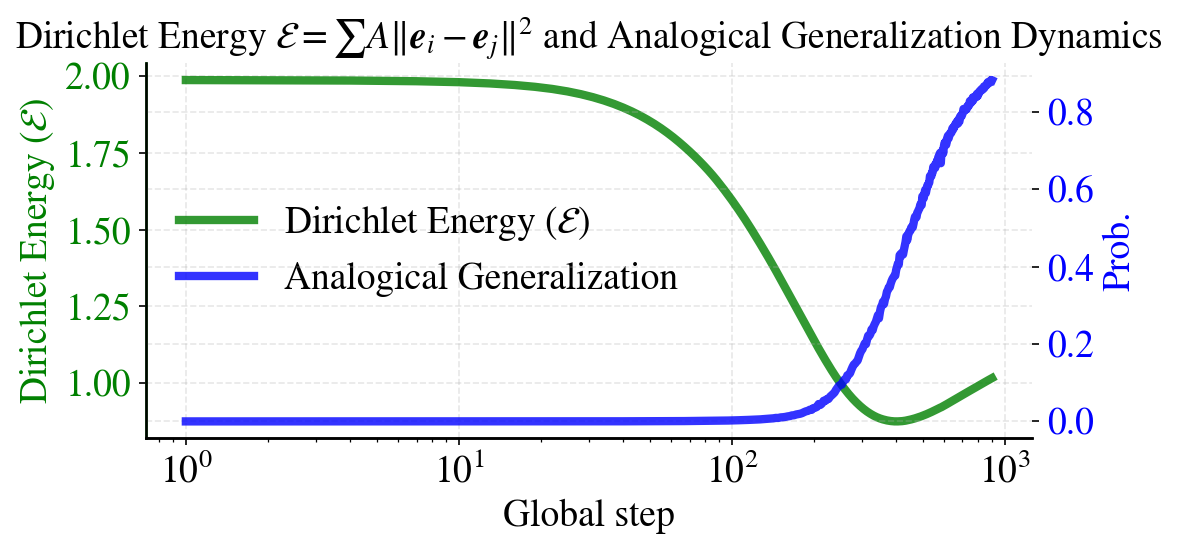

In [42]:
import matplotlib as mpl

mpl.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
})

fig, ax1 = plt.subplots(figsize=(8,4))

# ----- left axis: Dirichlet Energy -----
l1, = ax1.plot(
    history["step"],
    history["dirichlet"],
    label=r"Dirichlet Energy ($\mathcal{E}$)",
    color="green",
    alpha=0.8,
    linewidth=4
)
ax1.set_xlabel("Global step")
ax1.set_ylabel(r"Dirichlet Energy ($\mathcal{E}$)", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.spines["left"].set_color("green")

# ★ x-axis log scale
ax1.set_xscale("log")

# ----- right axis: P(correct) -----
ax2 = ax1.twinx()
l2, = ax2.plot(
    history["step"],
    history["pcorr"],
    label="Analogical Generalization",
    color="blue",
    alpha=0.8,
    linewidth=4
)
ax2.set_ylabel("Prob.", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.spines["right"].set_color("blue")

# grid (x-axis is shared)
ax1.grid(alpha=0.3)

# legend
lines  = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="center left")
ax1.set_title(
    r"Dirichlet Energy $\mathcal{E}=\sum A\|\boldsymbol{e}_i-\boldsymbol{e}_j\|^2$ "
    r"and Analogical Generalization Dynamics",
    fontsize=18
)
fig.tight_layout()
plt.savefig("dirichlet_energy.pdf")
plt.show()


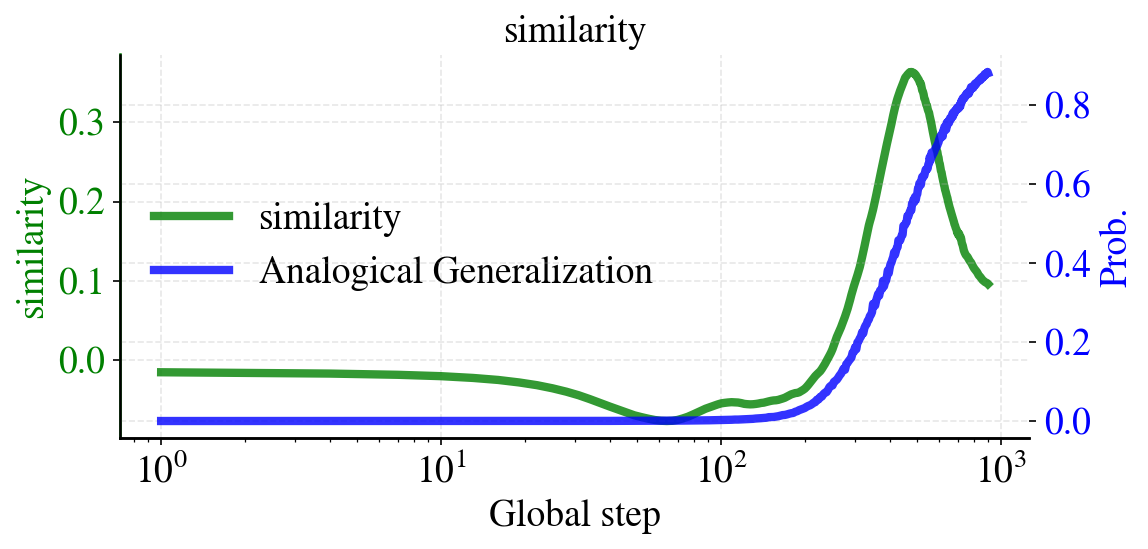

In [45]:
import matplotlib as mpl

mpl.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
})

fig, ax1 = plt.subplots(figsize=(8,4))

# ----- left axis: Dirichlet Energy -----
l1, = ax1.plot(
    history["step"],
    history["id_analogical_hi_ej_f_sim"],
    label=r"similarity",
    color="green",
    alpha=0.8,
    linewidth=4
)
ax1.set_xlabel("Global step")
ax1.set_ylabel(r"similarity", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.spines["left"].set_color("green")

# ★ x-axis log scale
ax1.set_xscale("log")

# ----- right axis: P(correct) -----
ax2 = ax1.twinx()
l2, = ax2.plot(
    history["step"],
    history["pcorr"],
    label="Analogical Generalization",
    color="blue",
    alpha=0.8,
    linewidth=4
)
ax2.set_ylabel("Prob.", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.spines["right"].set_color("blue")

# grid (x-axis is shared)
ax1.grid(alpha=0.3)

# legend
lines  = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="center left")
ax1.set_title(
    r"similarity",
    fontsize=18
)
fig.tight_layout()
plt.savefig("dirichlet_energy.pdf")
plt.show()


/tmp/ipython-input-3448898835.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_L = cm.get_cmap("Reds")
/tmp/ipython-input-3448898835.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_R = cm.get_cmap("Blues")


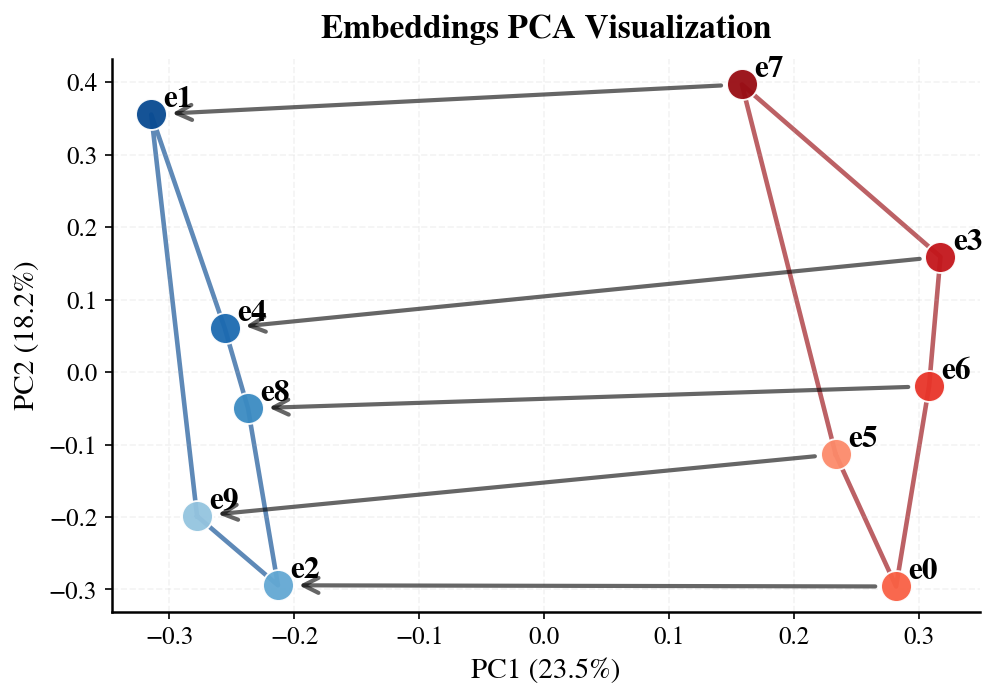

In [43]:
import re, json
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- assume you already have:
# vocab_path (str), model (with tok_emb), f_map_dict (dict like {'<e_5>': '<e_9>', ...})

# --------
# Load vocab + embeddings
# --------
with open(vocab_path, "r", encoding="utf-8") as f:
    vocab = json.load(f)
tok2id = {t: i for i, t in enumerate(vocab)}

W = model.tok_emb.weight.detach().cpu().numpy()  # [V, d]

# --------
ENTITY_RE = re.compile(r"^<e_(\d+)>$")
entity_vocab_ids, entity_ent_ids = [], []
for vid, tok in enumerate(vocab):
    m = ENTITY_RE.match(tok)
    if m:
        entity_vocab_ids.append(vid)
        entity_ent_ids.append(int(m.group(1)))

entity_vocab_ids = np.array(entity_vocab_ids, dtype=np.int64)
entity_ent_ids  = np.array(entity_ent_ids,  dtype=np.int64)

X_ent = W[entity_vocab_ids]  # [E, d]


# --------
# PCA fit on ALL tokens
# --------
pca = PCA(n_components=10, svd_solver="full", random_state=0)
Z_all = pca.fit_transform(X_ent)                     # [V, k]
evr = pca.explained_variance_ratio_

# --------
# Collect all entities (<e_#>) for faint background
# --------
ENTITY_RE = re.compile(r"^<e_(\d+)>$")
entity_vocab_ids, entity_ent_ids = [], []
for vid, tok in enumerate(vocab):
    m = ENTITY_RE.match(tok)
    if m:
        entity_vocab_ids.append(vid)
        entity_ent_ids.append(int(m.group(1)))

entity_vocab_ids = np.array(entity_vocab_ids, dtype=np.int64)
entity_ent_ids  = np.array(entity_ent_ids,  dtype=np.int64)
Z_ent = Z_all[entity_vocab_ids]                  # [E, k]
vid_to_entity_index = {int(vid): i for i, vid in enumerate(entity_vocab_ids)}

def token_to_ent_xy(tok: str):
    if tok not in tok2id:
        raise ValueError(f"token not in vocab: {tok}")
    vid = tok2id[tok]
    if vid not in vid_to_entity_index:
        raise ValueError(f"token is not an entity token: {tok}")
    ei = vid_to_entity_index[vid]
    x, y = Z_ent[ei, 0], Z_ent[ei, 1]
    ent_id = entity_ent_ids[ei]
    return x, y, ent_id, ei

# --------
# Build arrays for left/right points from mapping
# --------
left_toks  = list(f_map_dict.keys())
right_toks = [f_map_dict[k] for k in left_toks]

left_xy, right_xy = [], []
left_ids, right_ids = [], []
left_eidx, right_eidx = [], []

for lt, rt in zip(left_toks, right_toks):
    lx, ly, lid, lei = token_to_ent_xy(lt)
    rx, ry, rid, rei = token_to_ent_xy(rt)
    left_xy.append((lx, ly));  right_xy.append((rx, ry))
    left_ids.append(lid);      right_ids.append(rid)
    left_eidx.append(lei);     right_eidx.append(rei)

left_xy  = np.array(left_xy, dtype=float)   # [n,2]
right_xy = np.array(right_xy, dtype=float)

# Background: all entities except those involved in mapping
mask_bg = np.ones(len(Z_ent), dtype=bool)
mask_bg[np.array(left_eidx, dtype=int)] = False
mask_bg[np.array(right_eidx, dtype=int)] = False
Z_bg = Z_ent[mask_bg]

# --------
# helper: connect points as a polygon by angle order (pentagon-ish)
# --------
def polygon_order(points_xy: np.ndarray) -> np.ndarray:
    """Return indices that sort points around centroid by polar angle."""
    c = points_xy.mean(axis=0, keepdims=True)  # [1,2]
    angles = np.arctan2(points_xy[:, 1] - c[0, 1], points_xy[:, 0] - c[0, 0])
    return np.argsort(angles)

def draw_polygon(ax, points_xy: np.ndarray, order: np.ndarray, *, lw=2.0, alpha=0.8, color=None):
    """Draw closed polygon following order."""
    P = points_xy[order]
    P_closed = np.vstack([P, P[0:1]])
    ax.plot(P_closed[:, 0], P_closed[:, 1], linewidth=lw, alpha=alpha, color=color, zorder=1)

# compute polygon orders for left/right
ord_L = polygon_order(left_xy)
ord_R = polygon_order(right_xy)

# --------
# Gradual colors per entity (by polygon order)
# --------
nL = len(left_xy)
nR = len(right_xy)

cmap_L = cm.get_cmap("Reds")
cmap_R = cm.get_cmap("Blues")

# choose a nice range: avoid too pale / too dark
colors_L = cmap_L(np.linspace(0.40, 0.90, nL))  # [nL,4]
colors_R = cmap_R(np.linspace(0.40, 0.90, nR))

# map each point index -> color (following polygon order)
left_color_by_idx = np.zeros((nL, 4))
right_color_by_idx = np.zeros((nR, 4))
for rank, idx in enumerate(ord_L):
    left_color_by_idx[idx] = colors_L[rank]
for rank, idx in enumerate(ord_R):
    right_color_by_idx[idx] = colors_R[rank]

# --------
# Plot
# --------
fig, ax = plt.subplots(figsize=(7, 5))

# faint background entities
ax.scatter(Z_bg[:, 0], Z_bg[:, 1], s=18, alpha=0.10, linewidths=0, edgecolors="none", zorder=0)

# connect within domain (pentagon)
draw_polygon(ax, left_xy,  ord_L, lw=2.2, alpha=0.65, color=colors_L[-1])
draw_polygon(ax, right_xy, ord_R, lw=2.2, alpha=0.65, color=colors_R[-1])

# left / right highlighted with gradual colors
s_big = 220
for i in range(nL):
    ax.scatter(
        left_xy[i, 0], left_xy[i, 1],
        s=s_big, alpha=0.95,
        linewidths=0.9, edgecolors="white",
        color=left_color_by_idx[i],
        zorder=3
    )
for i in range(nR):
    ax.scatter(
        right_xy[i, 0], right_xy[i, 1],
        s=s_big, alpha=0.95,
        linewidths=0.9, edgecolors="white",
        color=right_color_by_idx[i],
        zorder=3
    )

# arrows left -> right + labels (arrow colored by left color)
for (lx, ly), (rx, ry), lid, rid, cL in zip(left_xy, right_xy, left_ids, right_ids, left_color_by_idx):
    ax.annotate(
        "",
        xy=(rx, ry), xytext=(lx, ly),
        arrowprops=dict(
            arrowstyle="->",
            lw=2,
            alpha=0.60,
            color="black",
            shrinkA=10, shrinkB=10
        ),
        zorder=2
    )
    ax.text(lx + 0.01, ly + 0.01, f"e{lid}", fontsize=15, weight="bold", zorder=4)
    ax.text(rx + 0.01, ry + 0.01, f"e{rid}", fontsize=15, weight="bold", zorder=4)

# cosmetics
ax.set_title("Embeddings PCA Visualization", pad=10, fontsize=16, weight="bold")
ax.set_xlabel(f"PC1 ({evr[0]*100:.1f}%)", fontsize=14)
ax.set_ylabel(f"PC2 ({evr[1]*100:.1f}%)", fontsize=14)

ax.grid(True, alpha=0.15, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ticks smaller
ax.tick_params(axis="both", which="major", labelsize=12)
ax.minorticks_off()

# keep geometry undistorted (optional but usually nice)
# ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.savefig("pca_visualization_end_training.pdf")
plt.show()
